<a href="https://colab.research.google.com/github/virf96/Analisis_Texto/blob/master/Topic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de temas (topic models)

### Procesamiento del Lenguaje Natural

**Pablo Martínez Olmos,Vanessa Gómez Verdejo, Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />



## 1. Introducción

En procesado de lenguaje natural, un modelo de temas (*topic model*) es un tipo de análisis no supervisado para **encontrar los temas (*topics*) que se tratan en una colección de documentos**. Los modelos de temas son fundamentales para **organizar y entender colecciones no estructuradas de documentos**, aunque también se extienden a campos tales como la bioinformática o la visión por ordenador.

De manera intuitiva, en un documento que trata sobre un tema en particular uno esperaría que aparecieran palabras específicas con mayor frecuencia. Por ejemplo, en una noticia sobre política uno esperaría encontrar con mayor frecuencia palabras tales como diputado, partido, o votación. En un contrato de alquiler, palabras tales como arrendador o fianza. De esta forma, entenderemos un **tema como una distribución de probabilidad sobre las palabras de un vocabulario dado**. Esta distribución variará entre los distintos temas. Asímismo, se asume que **un documento no trata exclusivamente sobre un único tema**, sino que es una mezcla de varios de ellos. Por ejemplo, una noticia puede tratar a la par de política y economía.

Todo modelo de temas se basa en la siguientes suposiciones:
* Cada documento es una mezcla de temas
* Cada tema es distribución de probabilidad de palabras en un vocabulario dado, compartido por todos los temas.

Entenderemos por tanto que un modelo de temas busca, por un lado, encontrar de forma no supervisada la distribución de probabilidad de los distintos temas dentro de un cuerpo de documentos. Por otro lado, para cada documento, resumirá su contenido mediante una mezcla de los distintos temas. Dicho de otro modo, reducirá la dimensionalidad de su codificación BoW/TF-IDF a un vector de tantas dimensiones como temas hayamos predefinido.

En esta sesión, presentaremos los siguientes dos modelos de temas
* *Latent Semantic Analysis (LSA)* (también referido como Latent Semantic Indexing en este contexto)
* *Latent Dirichlet Allocation (LDA)*

Si bien el primero nos es ya conocido, describiremos su interpretablidad como un modelo de temas. LDA, es un algoritmo más potente y típicamente proporciona resultados mejores y más interpretables. Finalmente, presentaremos también **metodologías para validar la solución de un modelo de temas**, lo que nos será útil para seleccionar parámetros tales como el número $K$ de temas.


### 1.1 Una base de datos de artículos de investigación

Para ilustrar ambas técnicas, trabajaremos sobre el dataset [NeurIPS papers](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv). Este dataset contiene los títulos, abstract y texto de los artículos publicados en la conferencia [NeurIPS (antes NIPS)](https://nips.cc/), la  conferencia internacional más importante en aspecto relacionados con aprendizaje automático.

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline  
# Figures plotted inside the notebook
%config InlineBackend.figure_format = 'retina'
# High quality figures
import matplotlib.pyplot as plt

In [ ]:
papers =  pd.read_csv("http://www.tsc.uc3m.es/~olmos/BBVA/papers.csv")

#papers =  pd.read_csv("papers.csv")

In [ ]:
papers

source_id  year                                              title  \
0            27  1987                         Bit-Serial Neural Networks   
1            63  1987                        Connectivity Versus Entropy   
2            60  1987        The Hopfield Model with Multi-Level Neurons   
3            59  1987                               How Neural Nets Work   
4            69  1987  Spatial Organization of Neural Networks: A Pro...   
...         ...   ...                                                ...   
9675       5452  2019  Discrete Object Generation with Reversible Ind...   
9676       4799  2019  Adaptively Aligned Image Captioning via Adapti...   
9677       1827  2019         Fully Dynamic Consistent Facility Location   
9678       8693  2019      Efficient Rematerialization for Deep Networks   
9679       2302  2019  Flow-based Image-to-Image Translation with Fea...   

                                               abstract  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
9675  The success of generative modeling in continuo...   
9676  Recent neural models for image captioning usua...   
9677  We consider classic clustering problems in ful...   
9678  When training complex neural networks, memory ...   
9679  Learning non-deterministic dynamics and intrin...   

                                              full_text  
0     573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan...  
1     1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser  S...  
2     278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...  
3     442 \n\nAlan  Lapedes \nRobert  Farber \n\nThe...  
4     740 \n\nSPATIAL  ORGANIZATION  OF  NEURAL  NEn...  
...                                                 ...  
9675  Discrete Object Generation\n\nwith Reversible ...  
9676  Adaptively Aligned Image Captioning via\n\nAda...  
9677  Fully Dynamic Consistent Facility Location\n\n...  
9678  Efﬁcient Rematerialization for Deep Networks\n...  
9679  Flow-based Image-to-Image Translation\n\nwith ...  

[9680 rows x 5 columns]

Por acotar un poco el análisis, vamos a centrarnos en artículos publicados en los últimos 20 años. Para agilizar los tiempos de cómputo, vamos a reducir la base de datos a 5000 artículos escogidos aleatoriamente ...

In [ ]:
papers.dropna(inplace=True)

# Nos quedamos con 5000 documentos aleatorios

papers_red = papers.loc[papers['year']>=2001].sample(n=2000, random_state=1)



In [ ]:
papers_red

source_id  year                                              title  \
9188       6163  2019                    Geometry-Aware Neural Rendering   
4870       1297  2013  A multi-agent control framework for co-adaptat...   
6306       1350  2016  Interaction Screening: Efficient and Sample-Op...   
6555        784  2016  End-to-End Kernel Learning with Supervised Con...   
6907       1025  2017  Stochastic Optimization with Variance Reductio...   
...         ...   ...                                                ...   
4947        545  2013        Convex Relaxations for Permutation Problems   
5683       1552  2015                      Super-Resolution Off the Grid   
8046       3410  2018  M-Walk: Learning to Walk over Graphs using Mon...   
5045        447  2013                   Online PCA for Contaminated Data   
9451       2692  2019             Adaptive Cross-Modal Few-shot Learning   

                                               abstract  \
9188  Understanding the 3-dimensional structure of t...   
4870  In a closed-loop brain-computer interface (BCI...   
6306  We consider the problem of learning the underl...   
6555  In this paper, we introduce a new image repres...   
6907  Stochastic optimization algorithms with varian...   
...                                                 ...   
4947  Seriation seeks to reconstruct a linear order ...   
5683  Super-resolution is the problem of recovering ...   
8046  Learning to walk over a graph towards a target...   
5045  We consider the online Principal Component Ana...   
9451  Metric-based meta-learning techniques have suc...   

                                              full_text  
9188  Geometry-Aware Neural Rendering\n\nJosh Tobin\...  
4870  A multi-agent control framework for co-adaptat...  
6306  Interaction Screening: Efﬁcient and Sample-Opt...  
6555  End-to-End Kernel Learning with\n\nSupervised ...  
6907  Stochastic Optimization with Variance Reductio...  
...                                                 ...  
4947  Convex Relaxations for Permutation Problems\n\...  
5683  Super-Resolution Off the Grid\n\nQingqing Huan...  
8046  M-Walk: Learning to Walk over Graphs\n\nusing ...  
5045  Online PCA for Contaminated Data\n\nJiashi Fen...  
9451  Adaptive Cross-Modal Few-shot Learning\n\nChen...  

[2000 rows x 5 columns]

Podemos ver que la distribución por años tampoco es uniforme, el crecimiento de esta conferencia es exponencial en los últimos años ...

<AxesSubplot:>

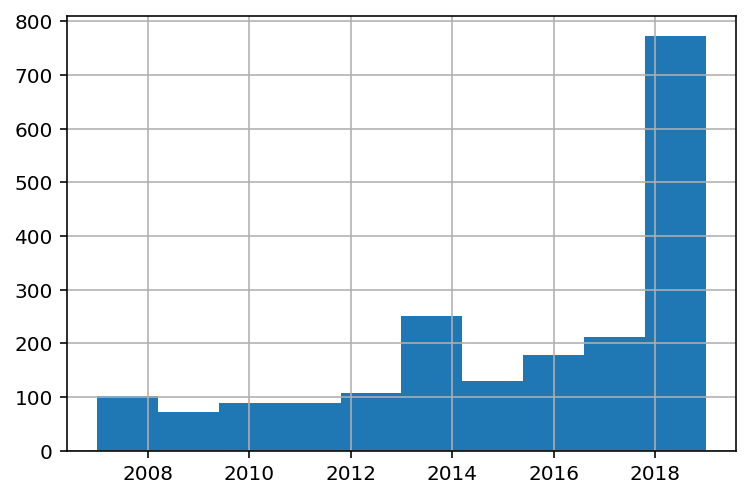

In [ ]:
papers_red['year'].hist()

Vamos a preprocesar el texto de los artículos, eliminando stopping words, signos de puntuación y tokens con caracteres no alfabéticos. De nuevo, por agilizar nos quedamos con los primeros 3000 caracteres (~ 500 palabras) por texto. Esto debería ser suficiente para cubrir el abstract/introducción de cada artículo ...

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")

list_processes = ["ner"]

for l in list_processes:
    nlp.disable_pipe(l) 
    
limit = 3000

papers_proc = [nlp(c[:limit]) if len(c)>limit else nlp(c) for c in papers_red['full_text']]

def normalize(doc):
    
    return [w for w in doc if not w.is_stop and not w.is_punct and w.is_alpha] # Solo tokens alfabéticos

# eliminamos stopping words, puntuaciones y tokens sin word embedding
papers_norm = [normalize(c) for c in papers_proc]

# Pasamos a modo texto
papers_text = [[w.lemma_.lower() for w in c] for c in papers_norm]

In [ ]:
# Pasamos a modo texto
papers_norm[0][5].lemma_

'Tobin'

Vamos a calcular también la matriz TF-IDF

In [ ]:
import gensim

D = gensim.corpora.Dictionary(papers_text)

no_below = 10 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(keep_n=2000)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 2000 terms
First terms in the dictionary:
0 : ability
1 : admit
2 : advance
3 : agent
4 : ai
5 : application
6 : approach
7 : arbitrary
8 : attention
9 : augment


In [ ]:
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

corpus_bow = [D.doc2bow(doc) for doc in papers_text]

model = TfidfModel(corpus_bow)  

corpus_tfidf = model[corpus_bow]

n_tokens = len(D)
num_docs = len(corpus_bow)
# Convert TFIDF representacion
corpus_tfidf_mat = corpus2dense(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs)

In [ ]:
corpus_tfidf_mat.shape

(2000, 2000)

## 2. Latent Semantic Analysis (Latent Semantic Indexing)

Recurrimos de nuevo al método LSA y la aproximación de rango $K$ basada en la descomposición SVD de la matriz TF-IDF del grupo de documentos. En esta descomposición

- Cada palabra está representada por un vector $\mathbf{u}_i, i=1,\ldots,m$ de dimensión $K$. 
- Cada documento está representado por un vector $\mathbf{v}_j, j=1,\ldots,n$ de dimensión $K$.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LSA_topic.png' width=800 />



### 2.1 Implementación con `scipy`

In [ ]:
# Utlizando la matriz numpy TF-IDF, podemos implementar LSA como hemos venido haciendo

from scipy.sparse.linalg import svds  # Función para calcular la descomposición en valores singulares

K = 5 # Dimensión de bajo rango (Número de temas)

u, s, vt = svds(corpus_tfidf_mat, k=K)  
print(u.shape, s.shape, vt.shape)
term_topic_mat, singular_values, topic_document_mat = u, s, vt

(2000, 5) (5,) (5, 2000)



Las matrices $\mathbf{U}$ y $\mathbf{V}$ son reales y por tanto sus elementos puedes ser tanto positivos como negativos. Esto dificulta la interpretabilidad de los temas. Para intentar interpretar cada temas, imprimamos las 5 palabras con mayor peso positivo y negativo:

In [ ]:
nwords = 20

for k in range(K):
    
    idx_words = np.argsort(term_topic_mat[:,k])
    
    words_neg = [D[i] for i in idx_words[:nwords] if term_topic_mat[i,k]<0]
    
    words_pos = [D[i] for i in idx_words[-nwords:] if term_topic_mat[i,k]>0]
    
    print(f"tema #{k}: \n Contribuciones negativas: {words_neg}\n Contribuciones positivas: {words_pos}\n")
    print('-'*50)

tema #0: 
 Contribuciones negativas: ['inference', 'network', 'variational', 'gradient', 'spike', 'neural', 'graph', 'variable', 'posterior', 'bayesian', 'et', 'latent', 'al', 'neuron', 'deep', 'probabilistic', 'markov', 'mcmc', 'layer', 'stochastic']
 Contribuciones positivas: ['scene', 'classiﬁcation', 'online', 'arm', 'query', 'classiﬁer', 'norm', 'clustering', 'visual', 'k', 'loss', 'feature', 'learner', 'bandit', 'regret', 'matrix', 'rank', 'object', 'label', 'image']

--------------------------------------------------
tema #1: 
 Contribuciones negativas: ['gradient', 'network', 'deep', 'sgd', 'neural', 'descent', 'layer', 'convex', 'stochastic', 'image', 'training', 'f', 'loss', 'optimization', 'convergence', 'rate', 'x', 'train', 'architecture', 'cnn']
 Contribuciones positivas: ['markov', 'spectral', 'similarity', 'social', 'kernel', 'causal', 'vertex', 'structure', 'variable', 'agent', 'latent', 'edge', 'graphical', 'inference', 'tree', 'matrix', 'cluster', 'clustering', 'node

Ciertamente, aunque vemos que los distintos temas difieren en térmimos clave reconocibles por cualquier conocedor del campo (kernel, clustering, banding, reinforcement, neural, network , ...), el tener contribuciones de signo tanto positivo como negativo dificulta la interpretabilidad de los temas encontraddos. 

Una alternativa es seleccionar un artículo con una temática muy específica y ver la contribución de los distintos temas. 

In [ ]:
idx_paper = 47

print(papers_red.iloc[idx_paper]['title'])
print('\n')
print(papers_red.iloc[idx_paper]['abstract'])

Convolutional Neural Network Architectures for Matching Natural Language Sentences


Semantic matching is of central importance to many natural language tasks \cite{bordes2014semantic,RetrievalQA}. A successful matching algorithm needs to adequately model the internal structures of language objects and the interaction between them. As a step toward this goal, we propose convolutional neural network models for matching two sentences, by adapting the convolutional strategy in vision and speech. The proposed models not only nicely represent the hierarchical structures of sentences with their layer-by-layer composition and pooling, but also capture the rich matching patterns at different levels. Our models are rather generic, requiring no prior knowledge on language, and can hence be applied to matching tasks of different nature and in different languages. The empirical study on a variety of matching tasks demonstrates the efficacy of the proposed model on a variety of matching tasks and i

Dibujemos la contribución de cada tema en este artículo, multiplicando la correspondiente columna de $\mathbf{V}$ por el vector de valores singulares $\mathbf{s}$:

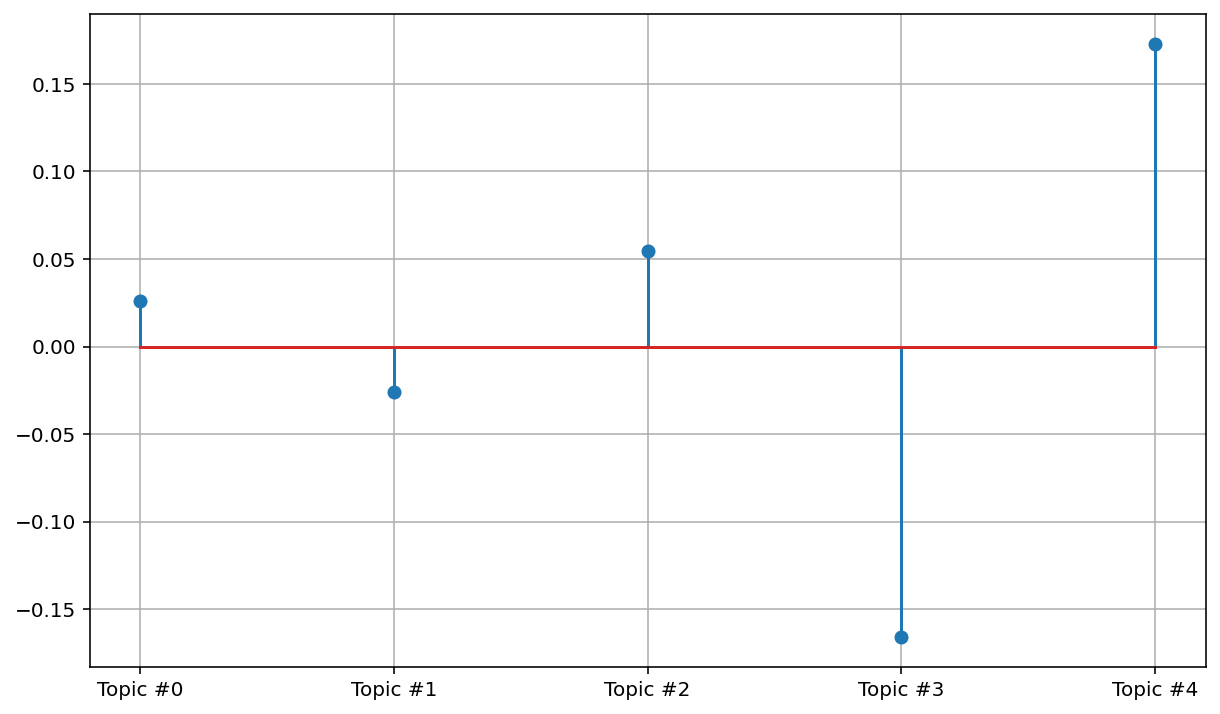

In [ ]:
plt.figure(figsize=(10,6))
plt.stem(range(K),topic_document_mat[:,idx_paper]*singular_values)
plt.grid()
plt.xticks(ticks=range(K),labels=['Topic #'+str(k) for k in range(K)])
plt.show()

Podemos comprobar cómo en los temas que contribuyen más a este documento palabras como *deep*, *neural*, *network*, *language* son relevantes. 

### 2.3 Implementación de LSA con gensim

Gensim incorpora el método LSA en su [catálogo](https://radimrehurek.com/gensim/models/lsimodel.html). Con respecto a la implementación anterior, la implementación de gensim tiene ventajas prácticas:
* Computación distribuida
* No requiere una matriz numpy densa, utiliza la codififación TF-IDF *sparse*
* Posibilidad de inclusión a posteriori de nuevos documentos al modelo
* Implementación eficiente basada en [este artículo](https://arxiv.org/pdf/1102.5597.pdf)

In [ ]:
from gensim.models import LsiModel

model = LsiModel(corpus_tfidf, num_topics=5, id2word=D)


Obtenemos la matriz de temas $\mathbf{U}$ usando el método `get_topics()`:

In [ ]:
term_topic_mat_gensim = model.get_topics().T

In [ ]:
term_topic_mat_gensim.shape

(2000, 5)

Y podemos ver un resumen de los temas con `print_topics()`, este muestra las palabras con mayor **valor absoluto**:

In [ ]:
model.print_topics(num_words=15)

[(0,
  '-0.128*"network" + -0.109*"image" + -0.099*"graph" + -0.092*"feature" + -0.089*"function" + -0.089*"matrix" + -0.087*"gradient" + -0.084*"neural" + -0.083*"al" + -0.083*"kernel" + -0.083*"et" + -0.082*"deep" + -0.081*"distribution" + -0.078*"x" + -0.078*"inference"'),
 (1,
  '0.304*"image" + 0.187*"object" + -0.181*"x" + -0.172*"f" + 0.158*"network" + -0.154*"convex" + -0.149*"matrix" + 0.148*"visual" + -0.127*"gradient" + -0.126*"n" + 0.109*"deep" + 0.104*"representation" + -0.104*"k" + 0.104*"scene" + -0.101*"optimization"'),
 (2,
  '0.384*"agent" + 0.380*"policy" + 0.253*"reward" + 0.221*"action" + 0.206*"rl" + 0.204*"reinforcement" + 0.163*"environment" + 0.149*"exploration" + -0.148*"graph" + -0.143*"image" + 0.143*"regret" + 0.134*"game" + 0.122*"bandit" + 0.118*"decision" + -0.111*"kernel"'),
 (3,
  '0.524*"graph" + -0.217*"gradient" + 0.180*"node" + 0.179*"clustering" + -0.152*"network" + -0.146*"deep" + -0.143*"sgd" + 0.141*"cluster" + -0.123*"neural" + -0.122*"descent

Y obtener el vector de temas de un documento dado a partir de su codificación TF-IDF ...

[(0, -0.17284098449564386), (1, 0.16649463321056612), (2, -0.05358819717098576), (3, -0.025619824807702113), (4, 0.02339123799767821)]


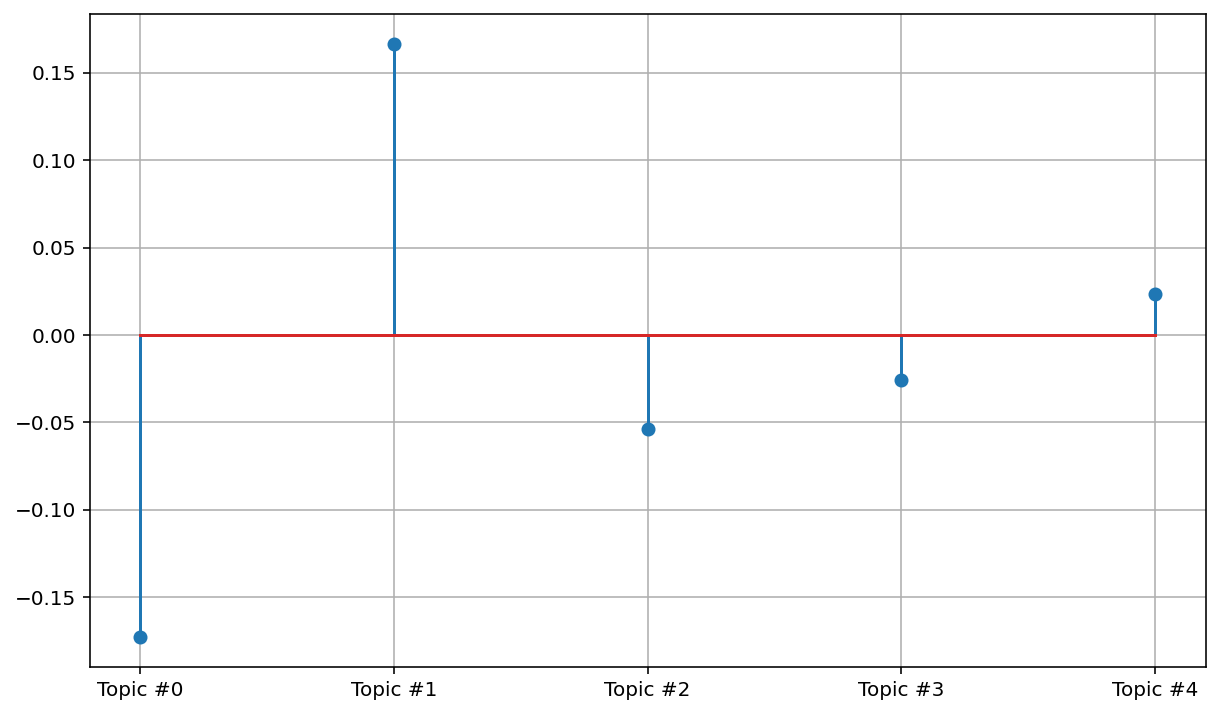

In [ ]:
print(model[corpus_tfidf[idx_paper]])

plt.figure(figsize=(10,6))
plt.stem(range(K),[s[1] for s in model[corpus_tfidf[idx_paper]]])
plt.grid()
plt.xticks(ticks=range(K),labels=['Topic #'+str(k) for k in range(K)])
plt.show()

## 3. Latent Dirichlet Allocation (LDA)

LDA es un tipo particular de lo que conocemos en ML como **modelo probabilístico basado en variables latentes**, cuyo objetivo es estimar la densidad de probabilidad de los datos. Una variable *latente* es una variable típicamente de **baja dimensión y no observada** encargada de capturar la **correlación entre las distintos atributos del dato**.

### 3.1 Un ejemplo sencillo de modelo generativo con variables latentes: estimación de densidad con modelos de mezcla de Gaussianas (GMMs)

Supongamos que disponemos de un conjunto de vectores reales $\mathbf{x}_n$, $n=1,\ldots,N$ con $\mathbf{x}_n\in\mathbb{R}^D$. En un GMM con $K$ componentes, asumimos que los datos se han generado de acuerdo al siguiente proceso:

1) Para muestrear el dato $\mathbf{x}_n$, primero muestreamos una variable aleatoria discreta $z_n\in\{0,\ldots,K-1\}$ con probabilidades $\pi_0,\ldots,\pi_{K-1}$:

$$z_n\sim \text{Categórica}\left(\pi_0,\ldots,\pi_{K-1}\right)$$

2) Dada la muestra $z_n=\tilde{k}$, el dato $\mathbf{x}_n$ se muestrea de una Gaussiana $D$-dimensional con media $\mathbf{\mu}_\tilde{k}$ y matriz de covarianza $\mathbf{\Sigma}_\tilde{k}$. Es decir, según la componente muestreada, tenemos una media y matriz de covarianza distintas.


Este proceso equivale a ajustar a nuestros datos una función densidad de probabilidad parametrizada del siguiente modo:

\begin{align}
p(\mathbf{x}) =\int p(\mathbf{x},z) dz = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)
\end{align}

donde $(\pi_1,\ldots,\pi_K)$, $(\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K)$, $(\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K)$ son los **parámetros del modelo**.



#### Entrenamiento de un GMM

Los parámetros del modelo se escogen para maximizar la **probabilidad de los datos ya observados o evidencia**:

$$ \max_{(\pi_1,\ldots,\pi_K),(\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K), (\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K)}  ~~\sum_{n=1}^{N} \log  p(\mathbf{x}_n) $$

Este problema se resuelve de forma numérica mediante un algoritmo iterativo conocido como **EM** (Expectation-Maximization).


In [ ]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4,cluster_std=0.60, random_state=0)
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_66928/1227553361.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


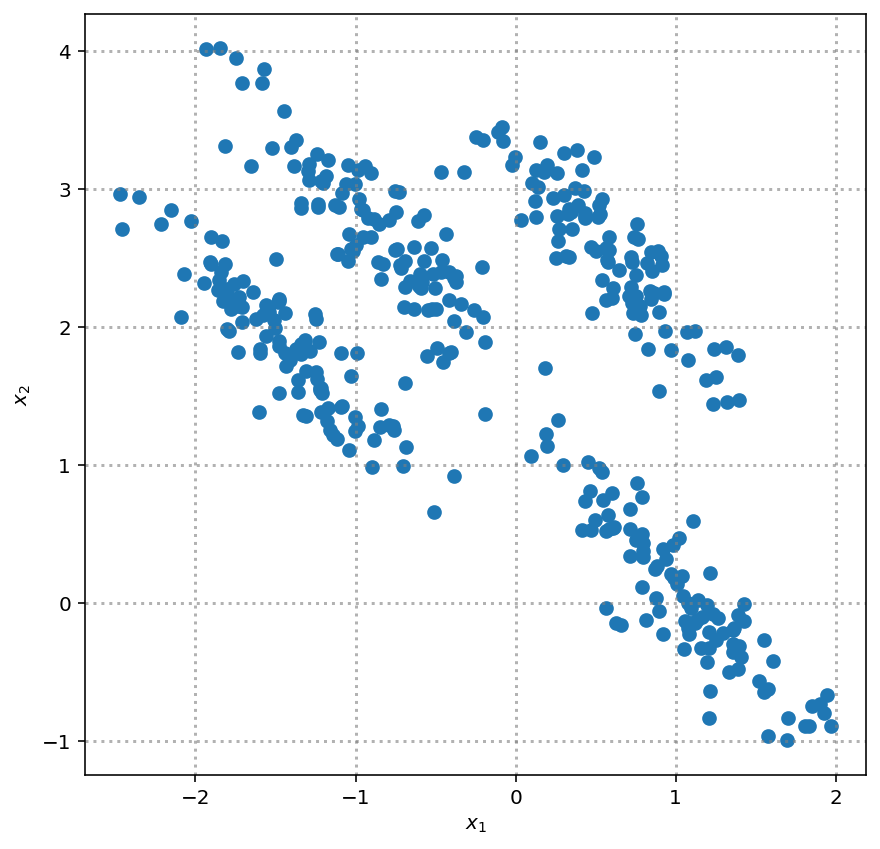

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_stretched[:, 0], X_stretched[:, 1], s=40, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

In [ ]:
from sklearn.mixture import GaussianMixture

# Seguimos teniendo mínimos locales. Relanzamos 10 veces y nos quedamos con el mejor
# Full para matrices de covarianza completas

gmm = GaussianMixture(n_components=4,covariance_type='full',n_init=10) 

gmm.fit(X_stretched) 

GaussianMixture(n_components=4, n_init=10)

/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_66928/2394191490.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
/var/folders/mp/m1pxr4954g9dg7ypdlqgrgl800029_/T/ipykernel_66928/2394191490.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


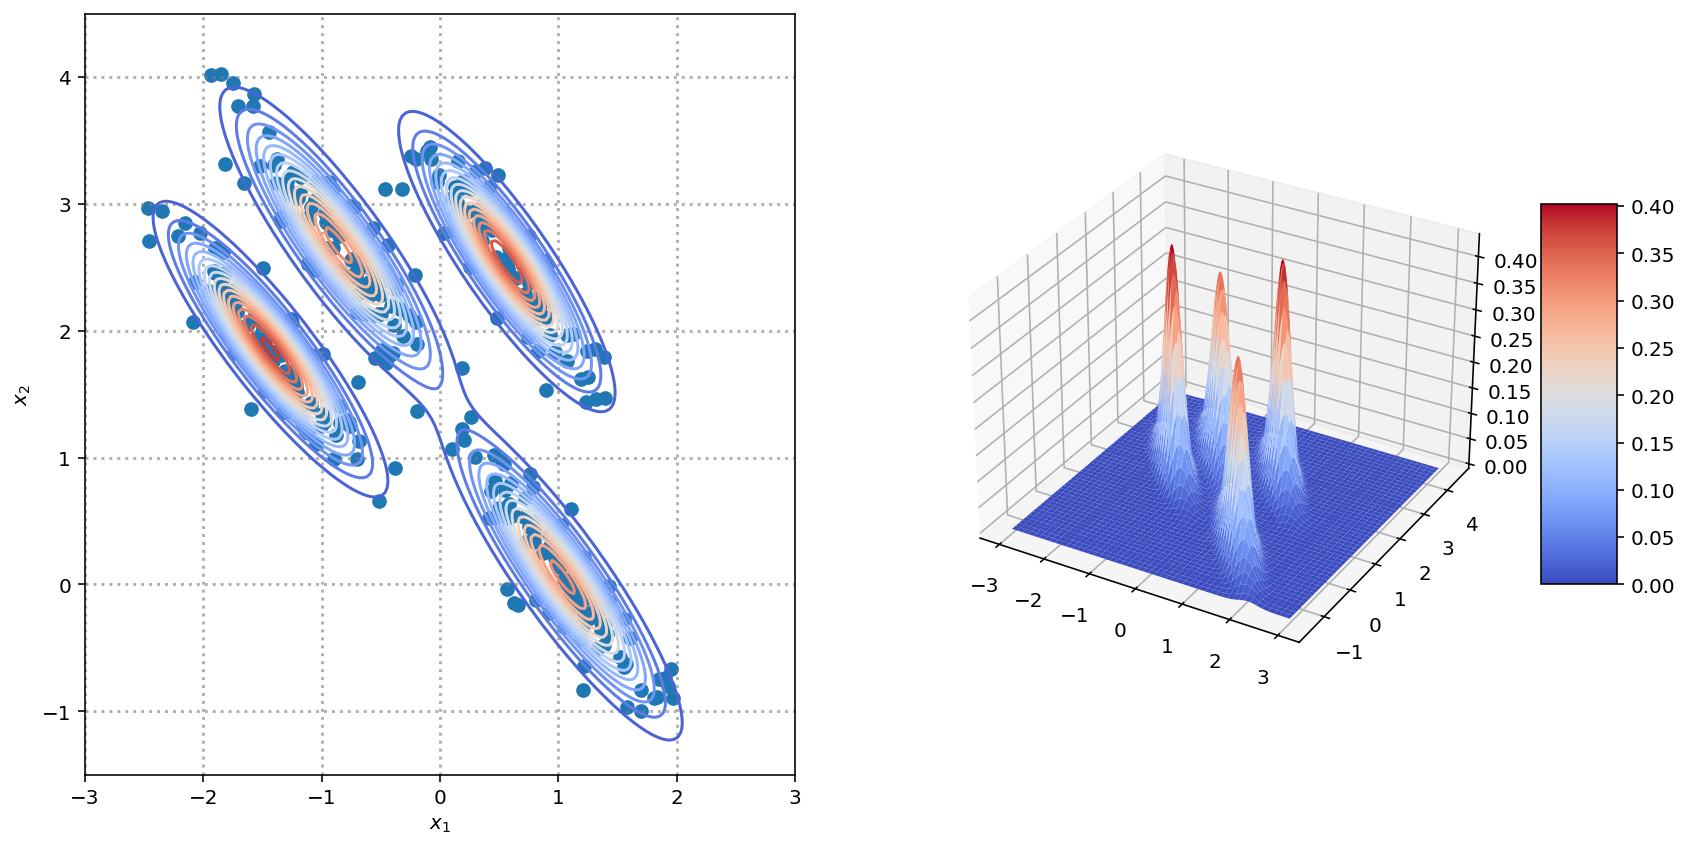

In [ ]:
from scipy.stats import multivariate_normal as mvn #Multivariate normal distribution
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Lets plot the pdf contour plot
intervals = 200

# Creamos una rejilla
x = np.linspace(-3, 3, intervals)
y = np.linspace(-1.5, 4.5, intervals)

X,Y = np.meshgrid(x,y)

xys = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluamos p(x) para cada punto de la rejilla

K=4

Zgmm = np.zeros(len(xys))
for k in range(K):
    Zgmm += gmm.weights_[k]*mvn(gmm.means_[k,:], gmm.covariances_[k]).pdf(xys)
    
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1)

Zgmm = Zgmm.reshape([intervals,intervals])
ax.contour(X, Y, Zgmm, 20, cmap=cm.coolwarm) 
ax.scatter(X_stretched[:, 0], X_stretched[:, 1], s=40, cmap='viridis')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, Zgmm, cmap=cm.coolwarm)
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


#### Estimación de la componente dado el dato

Una vez ajustado el GMM, dado un dato $\bf x$, podemos calcular la **probabilidad a posteriori** del grupo a partir de la cual se generó dicho dato:


$$P(z=k|\mathbf{x})= \frac{\pi_{k} \mathcal{N}(\mathbf{x}|\mathbf{\mu}_{k},\mathbf{\Sigma}_{k})}{\sum_{q=1}^K \pi_{q} \mathcal{N}(\mathbf{x}|\mathbf{\mu}_{q},\mathbf{\Sigma}_{q})}$$

En Sklearn, podemos calcular dichas probabilidades usando el método `predict_proba`. 

### 3.2 LDA para estimar la distribución de probabilidad de textos

Si bien un GMM es un modelo trasversal, que puede plantearse para cualquier colección de vectores vectores reales $\mathbf{x}_n$, $n=1,\ldots,N$, [**LDA es un modelo generativo probabilístico más adecuado para textos**](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf). En particular, asumiendo un número $K$ de temas, LDA plantea el siguiente proceso generativo:

<kbd>
<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA_modelo.png' width=600 />
</kbd>

El proceso anterior, matemáticamente se define como un **modelo de mezcla de variables categóricas** (en lugar de Gaussianas como en un GMM). La siguiente figura ([Fuente](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)), resume el proceso anterior:

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA1.png' width=800 />



Es importante notar que $\theta_d$, la proporción de temas en cada documento es una **representación vectorial del mismo que resume su información**. Este vector puede ser utilizado como vector de características para realizar otros algoritmos de aprendizaje (búsqueda de vecinos más cercanos, clasificación de documentos, etc ...).



Una descripción más formal del modelo generativo anterior es la siguiente. Hacemos uso de la distribución [Dirichlet uniforme](https://en.wikipedia.org/wiki/Dirichlet_distribution) para muestrerar distribuciones de probabilidad y la [distribución categórica](https://en.wikipedia.org/wiki/Categorical_distribution). 

<kbd>
<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA_modelo_2.png' width=600 />
</kbd>

El objetivo en el entrenamiento LDA es, **dada una colección de documentos representados como un BoW** $\mathbf{X}= [\mathbf{x}_1,\ldots,\mathbf{x}_N]$, obtener la distribución  a posteriori de probabilidad $\beta_k$ de las palabras por cada tema, y la proporción de temas por documento $\theta_d$:

$$ p(\beta_k|\mathbf{X}), \qquad k=1, \ldots,K$$

$$ p(\theta_d|\mathbf{X}), \qquad d=1,\ldots N$$

Para obtener muestras de las distribuciones a posteriori anteriores se hace uso de técnicas de Monte Carlo  basadas en cadenas de Markov.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDA2.png' width=1000 />

### LDA con gensim

El entrenamiento de LDA puede ser lento, especialmente cuando el tamaño del diccionario o el número de temas son muy grandes. Gensim proporciona una librería para entrenar un modelo [LDA](https://radimrehurek.com/gensim/models/ldamulticore.html) de forma online (podemos reentrenar a medida que incorporamos más documentos al dataset) y de forma distribuida, aprovechando todos los cores CPU para paralelizar y acelerar el entrenamiento del modelo.


In [ ]:
lda_model = gensim.models.LdaMulticore(corpus_bow, num_topics=5, id2word = D, passes=10) # Utilizamos BOW en lugar de TF-IDF!

En el código anterior, `passes` es el número de veces que el entrenamiento recorre todo el dataset. Está relacionado por tanto con el número de iteraciones realizadas pra entrenar el modelo. 

Entrenado el modelo, vamos a imprimir las 20 palabras más probables por tema. Notad ahora que hablamos de probabilidades y por tanto la influencia de cada palabra por tema se mide en números positivos entre 0-1. Esto, a diferencia de LSA, ayuda enormemente a la interpretabilidad del modelo:

In [ ]:
for idx, topic in lda_model.print_topics(num_words=20):
    print("Topic: %d \nWords: %s" %(idx, topic))
    print("\n")

Topic: 0 
Words: 0.019*"graph" + 0.018*"matrix" + 0.007*"rank" + 0.007*"sparse" + 0.007*"low" + 0.006*"vector" + 0.006*"node" + 0.006*"structure" + 0.006*"dimensional" + 0.006*"clustering" + 0.005*"norm" + 0.005*"network" + 0.005*"application" + 0.005*"analysis" + 0.005*"information" + 0.005*"word" + 0.005*"number" + 0.005*"high" + 0.004*"cluster" + 0.004*"approach"


Topic: 1 
Words: 0.014*"inference" + 0.011*"distribution" + 0.010*"variable" + 0.008*"process" + 0.008*"time" + 0.007*"approach" + 0.007*"bayesian" + 0.007*"kernel" + 0.007*"sample" + 0.006*"structure" + 0.006*"latent" + 0.005*"feature" + 0.005*"variational" + 0.005*"learn" + 0.005*"gaussian" + 0.005*"state" + 0.004*"probabilistic" + 0.004*"markov" + 0.004*"large" + 0.004*"tree"


Topic: 2 
Words: 0.018*"function" + 0.010*"x" + 0.008*"n" + 0.008*"set" + 0.007*"convex" + 0.007*"optimization" + 0.007*"f" + 0.007*"k" + 0.006*"linear" + 0.006*"loss" + 0.006*"sample" + 0.006*"point" + 0.005*"time" + 0.005*"bound" + 0.005*"opti

### Visualizando los temas con word clouds

Dibujemos ahora un wordcloud para visualizar mejor las palabras relevantes por cada tema

In [ ]:
#!pip install wordcloud 

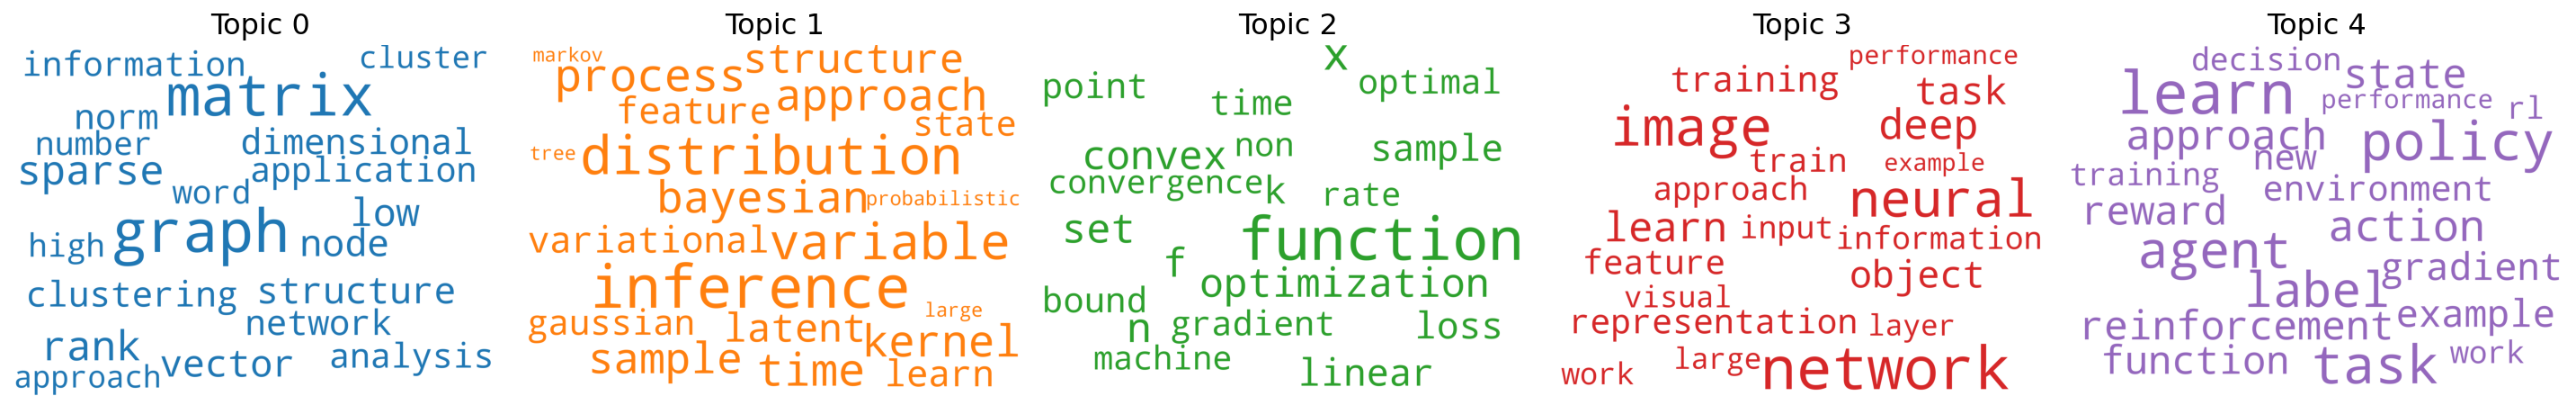

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(1, 5, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Podemos comprobar ahora cómo los temas están claramente diferenciados, lo que facilita su interpretabilidad. Si incrementamos a 10 temas esta coherencia se mantiene ....

In [ ]:
lda_model_10 = gensim.models.LdaMulticore(corpus_bow, num_topics=10, id2word = D, passes=20) # Utilizamos BOW en lugar de TF-IDF!

In [ ]:
for idx, topic in lda_model_10.print_topics(num_words=20):
    print("Topic: %d \nWords: %s" %(idx, topic))
    print("\n")

Topic: 0 
Words: 0.022*"policy" + 0.020*"agent" + 0.016*"learn" + 0.014*"action" + 0.013*"state" + 0.013*"reward" + 0.012*"reinforcement" + 0.012*"task" + 0.011*"function" + 0.010*"decision" + 0.009*"environment" + 0.009*"rl" + 0.008*"value" + 0.008*"approach" + 0.007*"exploration" + 0.007*"optimal" + 0.006*"multi" + 0.005*"system" + 0.005*"new" + 0.005*"human"


Topic: 1 
Words: 0.030*"inference" + 0.017*"variable" + 0.016*"distribution" + 0.014*"bayesian" + 0.013*"latent" + 0.013*"process" + 0.012*"variational" + 0.011*"approach" + 0.010*"gaussian" + 0.010*"probabilistic" + 0.009*"structure" + 0.008*"posterior" + 0.008*"markov" + 0.008*"likelihood" + 0.007*"learn" + 0.007*"sample" + 0.007*"mixture" + 0.006*"prior" + 0.006*"approximate" + 0.005*"state"


Topic: 2 
Words: 0.035*"image" + 0.016*"object" + 0.014*"label" + 0.011*"learn" + 0.010*"feature" + 0.010*"graph" + 0.009*"word" + 0.008*"task" + 0.008*"approach" + 0.007*"representation" + 0.006*"topic" + 0.006*"structure" + 0.006*"s

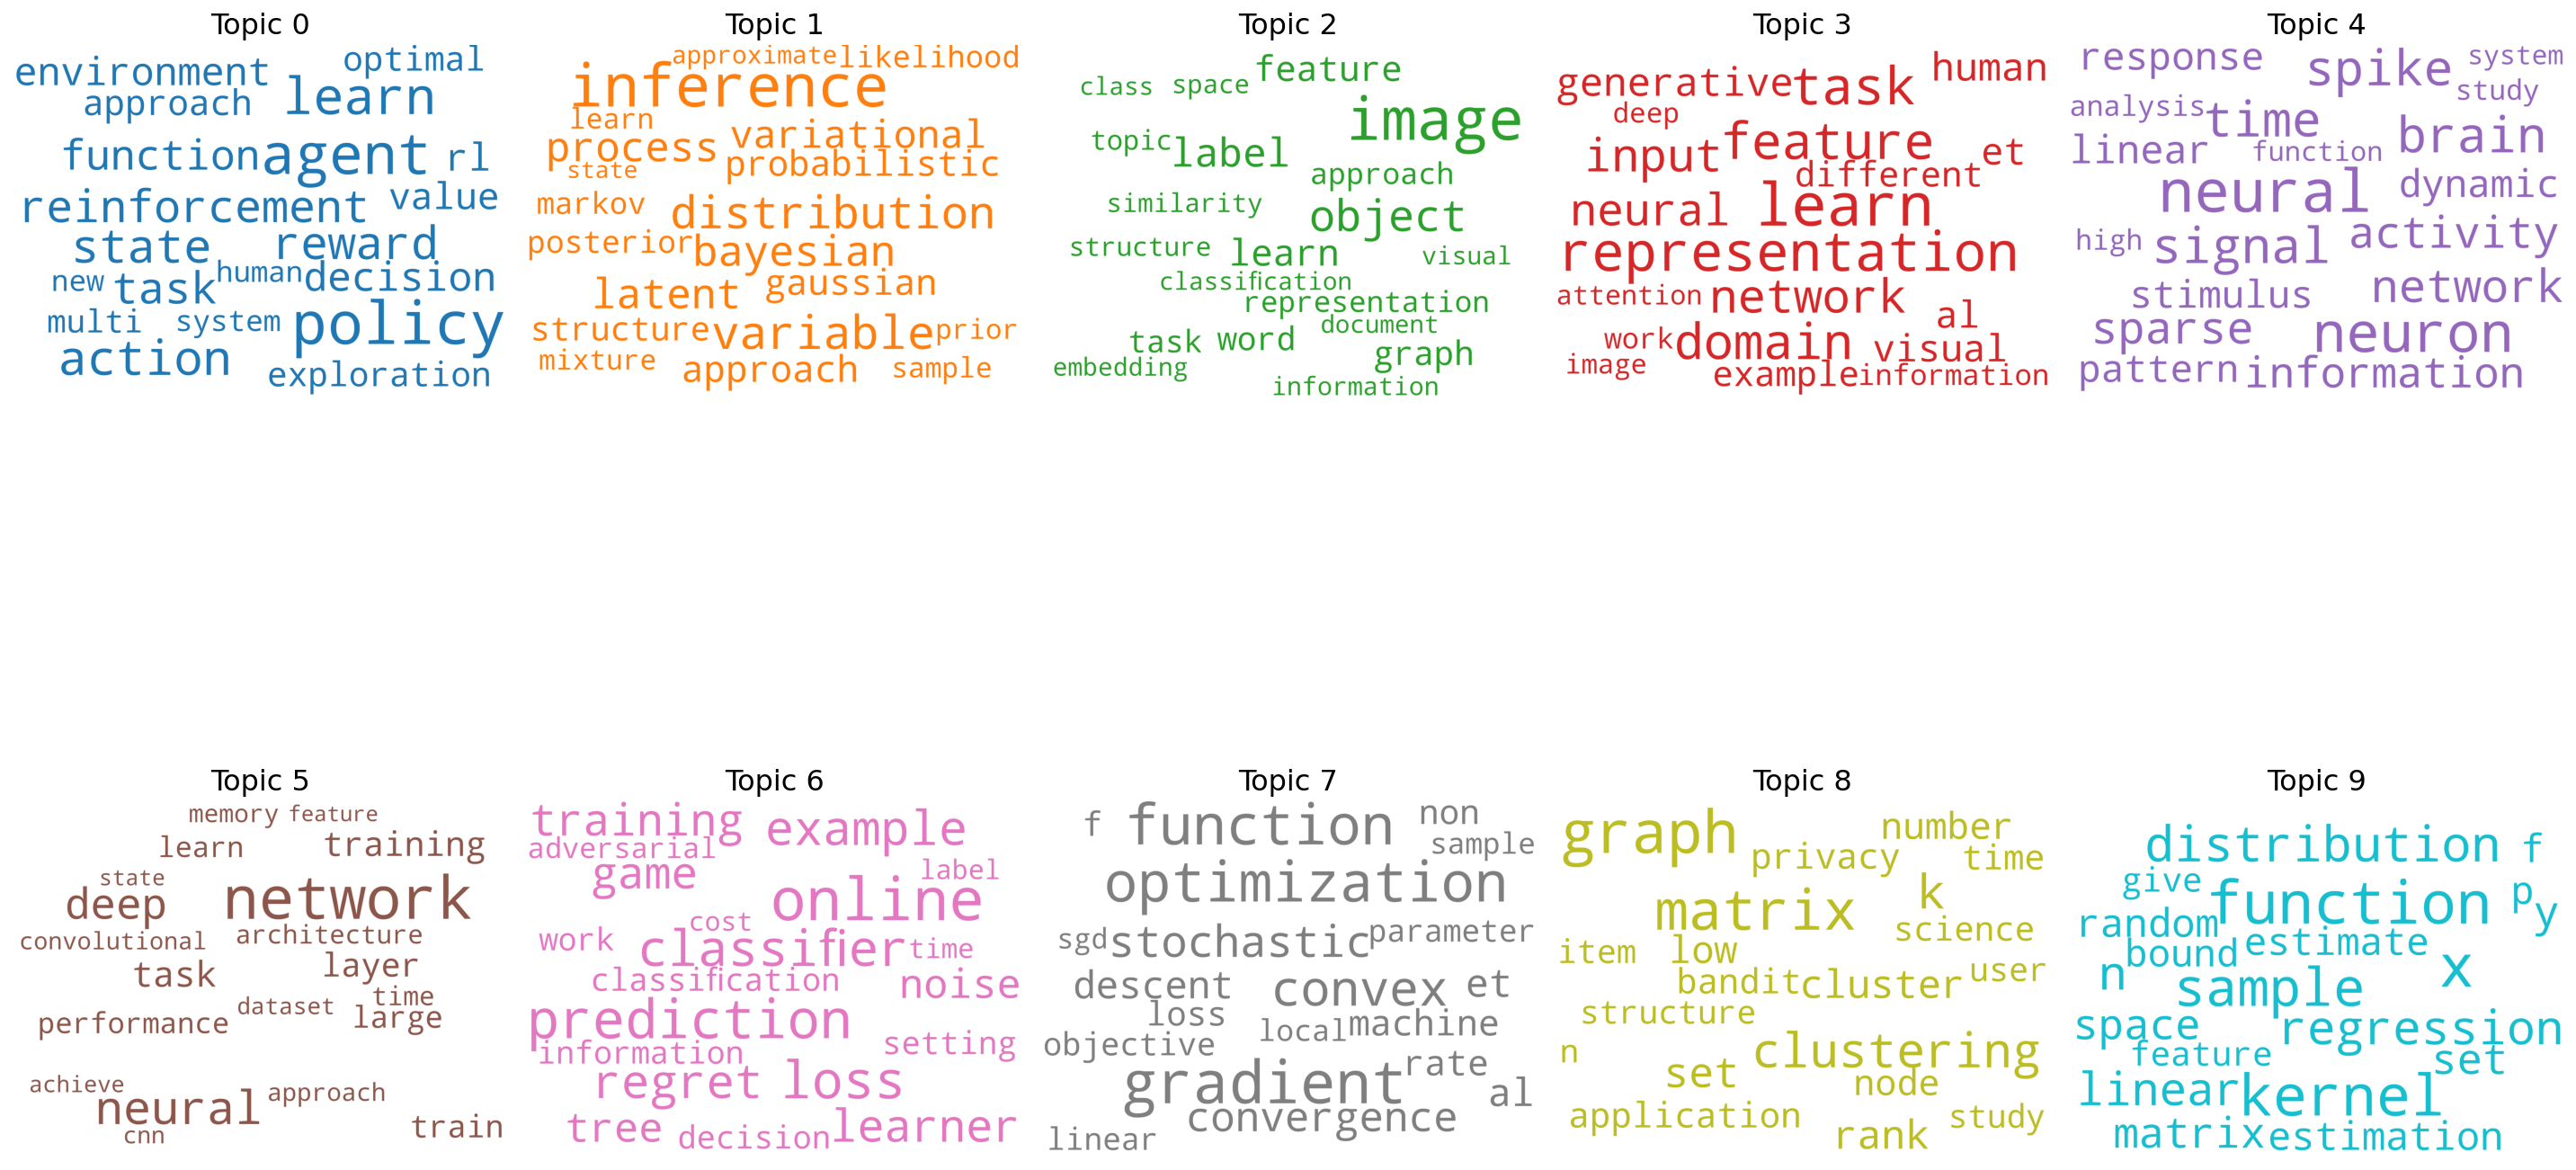

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_10.show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(2, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

De forma alternativa, podemos visualizar la frecuencia de las palabras más relevantes por tema usando gráficos de barras:

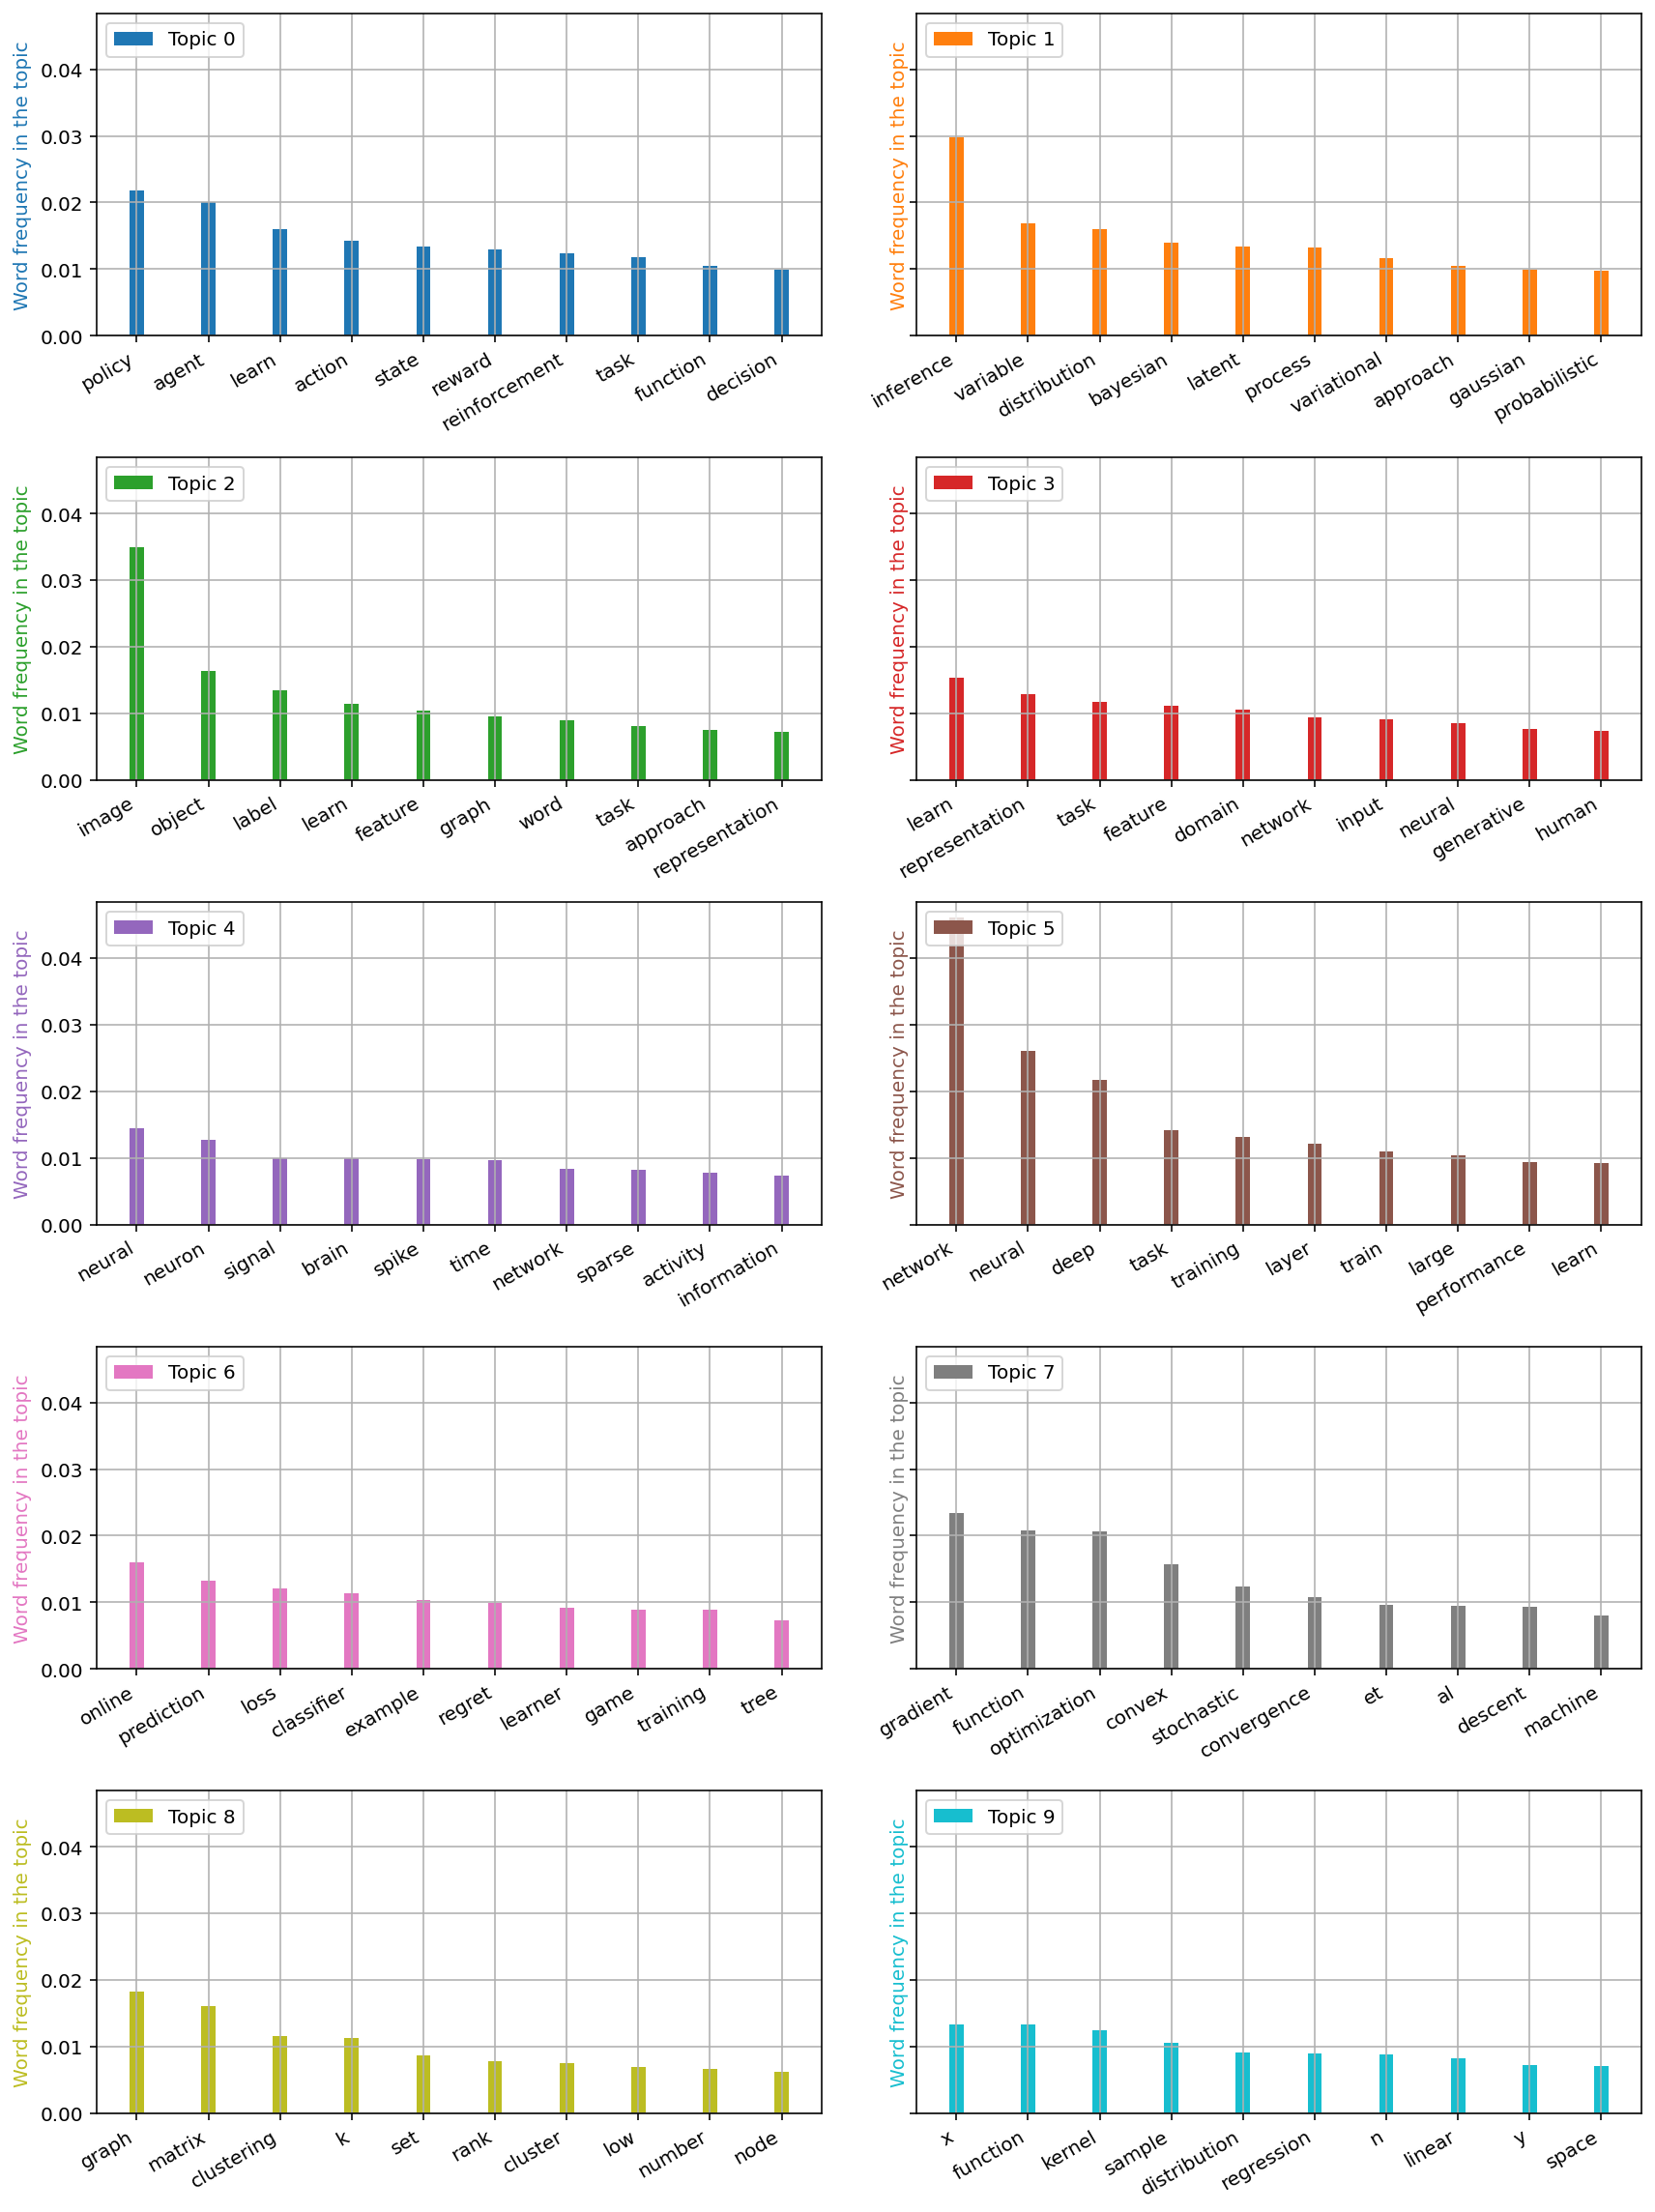

In [ ]:
import warnings   # I get some matplotlib warnings 
warnings.filterwarnings('ignore')

from collections import Counter
topics = lda_model_10.show_topics(formatted=False)
data_flat = [w for w_list in corpus_bow for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(12,16), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Topic '+str(i))
    ax.set_ylabel('Word frequency in the topic', color=cols[i])
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right',)
    ax.legend(loc='upper left'); 
    ax.grid()
    
fig.tight_layout(w_pad=2)    
plt.show()

### Extracción de los temas por documento

Del siguiente modo calculamos la proporción de cada tema por documento:

In [ ]:
tit = papers_red['title'].iloc[idx_paper]

print(tit)

Convolutional Neural Network Architectures for Matching Natural Language Sentences


In [ ]:
for index, score in lda_model[corpus_bow[idx_paper]]:
    print("\nScore: %f\t \n Topic: %r" %(score, lda_model.print_topic(index, 20)))


Score: 0.988222	 
 Topic: '0.020*"network" + 0.017*"image" + 0.015*"neural" + 0.009*"deep" + 0.009*"learn" + 0.008*"task" + 0.008*"object" + 0.007*"training" + 0.006*"representation" + 0.006*"feature" + 0.006*"train" + 0.006*"approach" + 0.005*"information" + 0.005*"input" + 0.005*"work" + 0.005*"visual" + 0.005*"large" + 0.004*"layer" + 0.004*"performance" + 0.004*"example"'


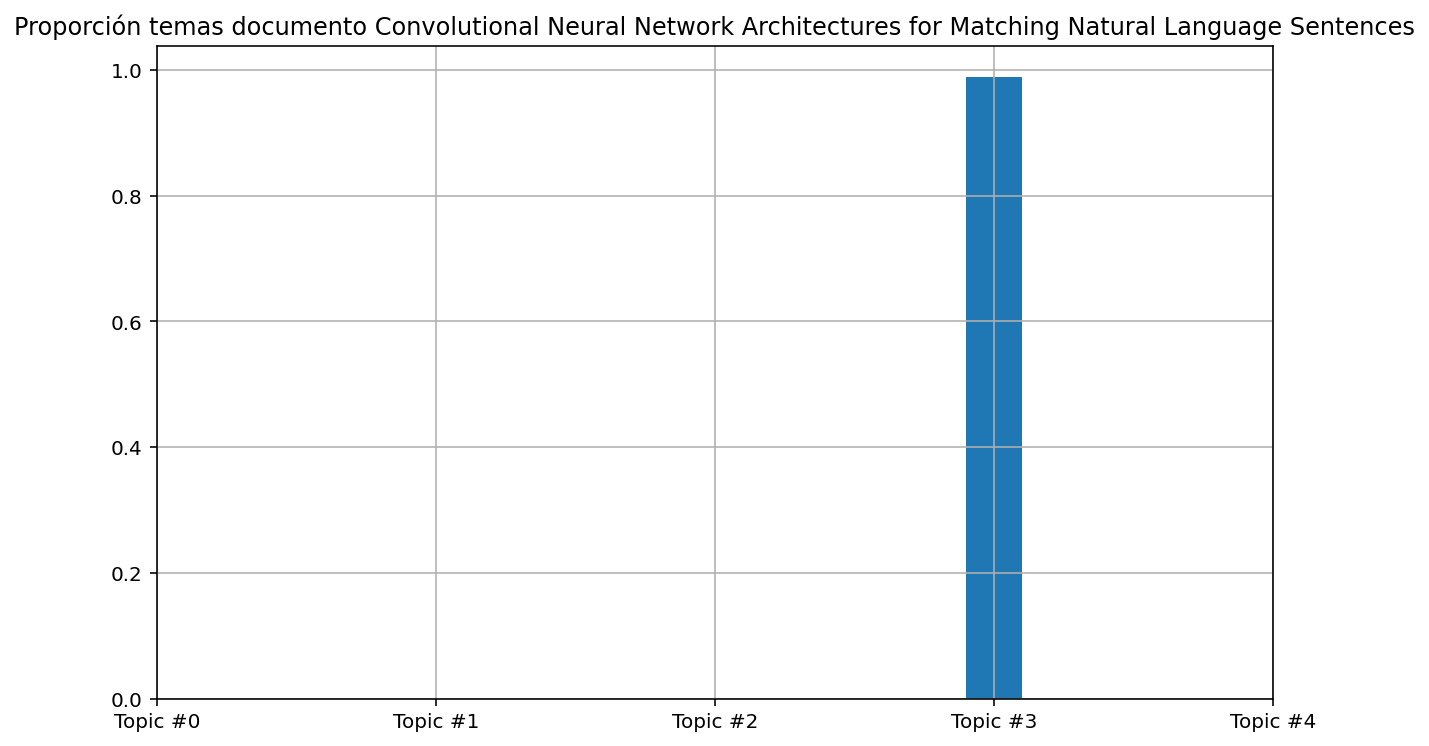

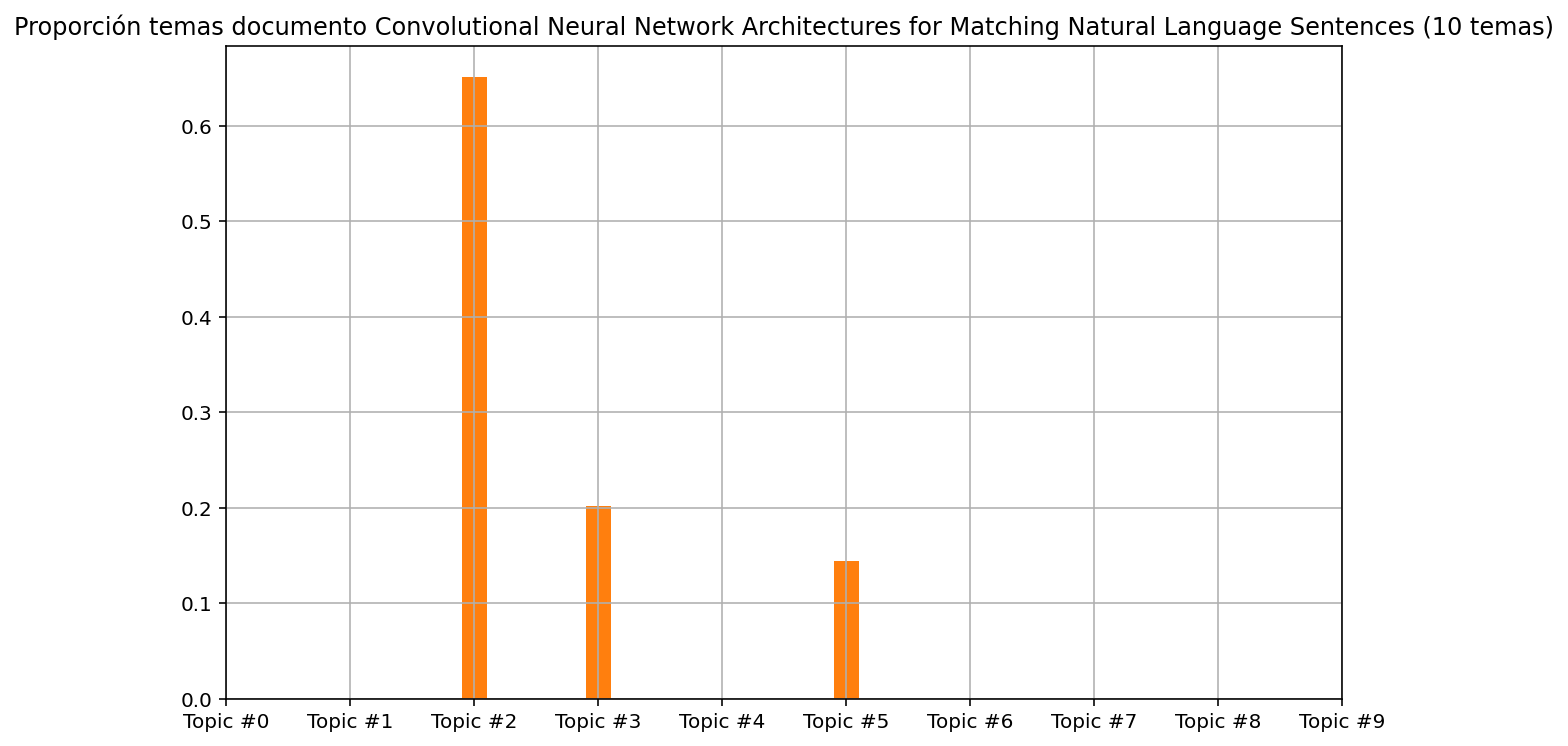

In [ ]:
plt.figure(figsize=(10,6))
plt.bar([s[0] for s in lda_model[corpus_bow[idx_paper]]],[s[1] for s in lda_model[corpus_bow[idx_paper]]],color=cols[0], width=0.2)
plt.grid()
plt.xticks(ticks=range(5),labels=['Topic #'+str(k) for k in range(5)])
plt.title(f'Proporción temas documento {tit}')
plt.show()


plt.figure(figsize=(10,6))
plt.bar([s[0] for s in lda_model_10[corpus_bow[idx_paper]]],[s[1] for s in lda_model_10[corpus_bow[idx_paper]]],color=cols[1], width=0.2)
plt.grid()
plt.xticks(ticks=range(10),labels=['Topic #'+str(k) for k in range(10)])
plt.title(f'Proporción temas documento {tit} (10 temas)')
plt.show()

Finalmente, con la siguiente función resumimos la proporción de temas para todos los artículos del dataset ...

In [ ]:
# Vamos a pasar a una matriz las proporciones de temas por documento

topics_doc = lda_model[corpus_bow]

topics_doc_10 = lda_model_10[corpus_bow]

In [ ]:
topics_doc[1530]

[(1, 0.15109526), (4, 0.84585065)]

In [ ]:
from gensim.matutils import corpus2dense

corpus_LDA_dense = corpus2dense(topics_doc, num_terms=5, num_docs=len(topics_doc)).T

corpus_LDA_dense_10 = corpus2dense(topics_doc, num_terms=10, num_docs=len(topics_doc)).T

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, texts.reset_index(drop=True)],axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_10, corpus=corpus_bow, texts=papers_red['title'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               2              0.4012   
1            1               3              0.4226   
2            2               8              0.5345   
3            3               5              0.5133   
4            4               7              0.8778   
5            5               9              0.5378   
6            6               9              0.9956   
7            7               9              0.4426   
8            8               0              0.3118   
9            9               2              0.7733   

                                            Keywords  \
0  image, object, label, learn, feature, graph, w...   
1  learn, representation, task, feature, domain, ...   
2  graph, matrix, clustering, k, set, rank, clust...   
3  network, neural, deep, task, training, layer, ...   
4  gradient, function, optimization, convex, stoc...   
5  x, function, kernel, sample, distribution, reg...   
6  x, function, kernel, sample, distribution, reg...   
7  x, function, kernel, sample, distribution, reg...   
8  policy, agent, learn, action, state, reward, r...   
9  image, object, label, learn, feature, graph, w...   

                                                Text  
0                    Geometry-Aware Neural Rendering  
1  A multi-agent control framework for co-adaptat...  
2  Interaction Screening: Efficient and Sample-Op...  
3  End-to-End Kernel Learning with Supervised Con...  
4  Stochastic Optimization with Variance Reductio...  
5  Near-Optimal-Sample Estimators for Spherical G...  
6  Optimal Linear Estimation under Unknown Nonlin...  
7  Time-dependent spatially varying graphical mod...  
8  Truncated Variance Reduction: A Unified Approa...  
9  A Probabilistic U-Net for Segmentation of Ambi...

> **Ejercicio:** Determine el  % de documentos dominados por un único tema (proporción mayor que 0.8).

In [ ]:
df_dominant_topic.loc[df_dominant_topic['Topic_Perc_Contrib']>0.8]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
4               4               7              0.8778   
6               6               9              0.9956   
13             13               7              0.8560   
31             31               4              0.8219   
33             33               1              0.8482   
...           ...             ...                 ...   
1983         1983               8              0.8592   
1984         1984               5              0.8582   
1988         1988               9              0.8522   
1990         1990               8              0.8499   
1999         1999               3              0.8213   

                                               Keywords  \
4     gradient, function, optimization, convex, stoc...   
6     x, function, kernel, sample, distribution, reg...   
13    gradient, function, optimization, convex, stoc...   
31    neural, neuron, signal, brain, spike, time, ne...   
33    inference, variable, distribution, bayesian, l...   
...                                                 ...   
1983  graph, matrix, clustering, k, set, rank, clust...   
1984  network, neural, deep, task, training, layer, ...   
1988  x, function, kernel, sample, distribution, reg...   
1990  graph, matrix, clustering, k, set, rank, clust...   
1999  learn, representation, task, feature, domain, ...   

                                                   Text  
4     Stochastic Optimization with Variance Reductio...  
6     Optimal Linear Estimation under Unknown Nonlin...  
13                Fast Rates for Regularized Objectives  
31    Identifying Alzheimer's Disease-Related Brain ...  
33                       Operator Variational Inference  
...                                                 ...  
1983             Community Detection on Evolving Graphs  
1984  Learning both Weights and Connections for Effi...  
1988        AUC optimization and the two-sample problem  
1990  GPyTorch: Blackbox Matrix-Matrix Gaussian Proc...  
1999             Adaptive Cross-Modal Few-shot Learning  

[398 rows x 5 columns]

In [ ]:
print(f"Hay un {df_dominant_topic.loc[df_dominant_topic['Topic_Perc_Contrib']>0.8].shape[0]/df_dominant_topic.shape[0]*100}% de documentos dominados casi en exclusiva por un único tema")

Hay un 19.900000000000002% de documentos dominados casi en exclusiva por un único tema


### Midiendo distancias entre documentos

> **Ejercicio:** Busque los 10 vecinos más cercanos a un artículo dado utilizando la distribución de temas por documento. Utilice como métrica la distancia euclídea.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distancias = euclidean_distances(corpus_LDA_dense_10[idx_paper,:].reshape([1,-1]),corpus_LDA_dense_10)

idx_neigh = np.argsort(distancias)[0]

print(f"Los 10 vecinos más cercanos del paper {tit} son:\n")

for i in range(10):
    
    tit2 = papers_red['title'].iloc[idx_neigh[i]]
    
    print(f" Vecino #{i}: {tit2}")
    print('-'*20)
    

Los 10 vecinos más cercanos del paper Convolutional Neural Network Architectures for Matching Natural Language Sentences son:

 Vecino #0: Convolutional Neural Network Architectures for Matching Natural Language Sentences
--------------------
 Vecino #1: Perfect Associative Learning with Spike-Timing-Dependent Plasticity
--------------------
 Vecino #2: Full-Gradient Representation for Neural Network Visualization
--------------------
 Vecino #3: Recognizing retinal ganglion cells in the dark
--------------------
 Vecino #4: Information Competing Process for Learning Diversified Representations
--------------------
 Vecino #5: RUBi: Reducing Unimodal Biases for Visual Question Answering
--------------------
 Vecino #6: Working hard to know your neighbor's margins: Local descriptor learning loss
--------------------
 Vecino #7: SpikeAnts, a spiking neuron network modelling the emergence of organization in a complex system
--------------------
 Vecino #8: Sanity Checks for Saliency Maps



A pesar de que la distancia euclídea pueda dar resultados razonables, dado que la representación LDA por documento es una **distribución de probabilidad**, lo más adecuado para medir distancias entre documentos es utilizar alguna **medida de distancia entre distributciones de probabilidad** tales como la [divergencia KL](https://es.wikipedia.org/wiki/Divergencia_de_Kullback-Leibler), su versión simétrica ([Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)), o [la distancia de Hellinger](https://en.wikipedia.org/wiki/Hellinger_distance). Veamos su definición. 

Dados dos documentos vectorizados con su representación LDA $\boldsymbol{\theta}_i$ y $\boldsymbol{\theta}_j$:

* **Divergencia KL:** $D_{\mathrm{KL}}(\boldsymbol{\theta}_i \| \boldsymbol{\theta}_j)=\sum_{m} \theta_{im} \ln \frac{\theta_{im}}{\theta_{jm}}$. Esta métrica es siempre positiva (solo 0 cuando $\theta_{im}=\theta_{im}$, $m=0,\ldots,K-1$), pero **no es simétrica**. Esto es, $D_{\mathrm{KL}}(\boldsymbol{\theta}_i \| \boldsymbol{\theta}_j)\neq D_{\mathrm{KL}}(\boldsymbol{\theta}_j \| \boldsymbol{\theta}_m)$.

* **Divergencia Jensen-Shannon:** es una extensión simétrica de la anterior $JSD\left(\boldsymbol{\theta}_i\| \boldsymbol{\theta}_j\right) = \frac{D_{\mathrm{KL}}(\boldsymbol{\theta}_i \| \boldsymbol{\theta}_j)+D_{\mathrm{KL}}(\boldsymbol{\theta}_j \| \boldsymbol{\theta}_i)}{2}$. Es positiva y simétrica y sí puede considerarse una distancia entre distribuciones.

* **Distancia de Hellinger**: puede considerarse una versión probabilística de la distancia euclídea $H(\boldsymbol{\theta}_i \| \boldsymbol{\theta}_j)=\frac{1}{\sqrt{2}} (\sum_{m=1}\left(\sqrt{\theta_{im}}-\sqrt{\theta_{jm}}\right)^{2})^{\frac{1}{2}}=(1-\sum_m \sqrt{\theta_{im}\theta_{jm}})^{\frac{1}{2}}$. Esta métrica toma valores en el rango $[0,1]$.







> **Ejercicio:** Busque los 10 vecinos más cercanos a un artículo dado utilizando la distribución de temas por documento. Utilice como métrica la distancia Hellinger y la distancia JSD.

In [ ]:
from gensim.matutils import hellinger

distancias = np.array([hellinger(corpus_LDA_dense_10[idx_paper,:], corpus_LDA_dense_10[d,:])
                       for d in range(len(topics_doc_10)) if d != idx_paper])

idx_neigh = np.argsort(distancias)

print(f"Los 10 vecinos más cercanos del paper {tit} son:\n")

for i in range(10):
    
    tit2 = papers_red['title'].iloc[idx_neigh[i]]
    
    print(f" Vecino #{i}: {tit2}")
    print('-'*20)
    


Los 10 vecinos más cercanos del paper Convolutional Neural Network Architectures for Matching Natural Language Sentences son:

 Vecino #0: Efficient Minimization of Decomposable Submodular Functions
--------------------
 Vecino #1: A multi-agent reinforcement learning model of common-pool resource appropriation
--------------------
 Vecino #2: On Lazy Training in Differentiable Programming
--------------------
 Vecino #3: Factor Modeling for Advertisement Targeting
--------------------
 Vecino #4: Learning Representations by Maximizing Mutual Information Across Views
--------------------
 Vecino #5: Efficient Formal Safety Analysis of Neural Networks
--------------------
 Vecino #6: Polynomial Semantic Indexing
--------------------
 Vecino #7: Sanity Checks for Saliency Maps
--------------------
 Vecino #8: On Learning Rotations
--------------------
 Vecino #9: Correlation clustering with local objectives
--------------------


In [ ]:
from gensim.matutils import jensen_shannon

distancias = np.array([jensen_shannon(corpus_LDA_dense_10[idx_paper,:], corpus_LDA_dense_10[d,:]) 
                       for d in range(len(topics_doc_10)) if d != idx_paper])

idx_neigh = np.argsort(distancias)

print(f"Los 10 vecinos más cercanos del paper {tit} son:\n")

for i in range(10):
    
    tit2 = papers_red['title'].iloc[idx_neigh[i]]
    
    print(f" Vecino #{i}: {tit2}")
    print('-'*20)
    

Los 10 vecinos más cercanos del paper Convolutional Neural Network Architectures for Matching Natural Language Sentences son:

 Vecino #0: Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering
--------------------
 Vecino #1: Small-Variance Asymptotics for Hidden Markov Models
--------------------
 Vecino #2: Kernel-Based Approaches for Sequence Modeling: Connections to Neural Methods
--------------------
 Vecino #3: Modeling Short-term Noise Dependence of Spike Counts in Macaque Prefrontal Cortex
--------------------
 Vecino #4: Beyond Online Balanced Descent: An Optimal Algorithm for Smoothed Online Optimization
--------------------
 Vecino #5: Learning to Navigate in Cities Without a Map
--------------------
 Vecino #6: Inferring Networks From Random Walk-Based Node Similarities
--------------------
 Vecino #7: Multi-output Polynomial Networks and Factorization Machines
--------------------
 Vecino #8: On Lazy Training in Differentiable Programming
---------

## 4. Métricas para la validación de modelos de temas

Al tratarse de modelos no supervisados, no disponemos de una métrica unívoca para la validación de parámetros de un modelo de temas (típicamente el número de temas). En este [articulo](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) se hace un resumen muy completo de las distintas métricas en un modelo de temas que típicamente se utilizan de forma combinada. Por una parte, tenemos **métricas de ajuste** del modelo a datos de validación:

* **LL: log-likelihood**: dado un documento con palabras $\mathbf{w}_d$, log-probabilidad de ser una muestra del modelo LDA entrenado:

$$\log p(\mathbf{w}_d) = \log \int p(\theta_d)\prod_{k=1}^{K}p(\beta_k)\prod_{j=1}^{D_d} p(w_{jd}|\beta_{z_{jd}})p(z_{jd}|\theta_d)~d\beta_1\ldots d\beta_k d\theta_d d\mathbf{z}_d$$

* **LP: log_perplexity**: dado un conjunto de validación $\mathcal{D}_{\text {val}} =\left(\mathbf{w}_1,\ldots,\mathbf{w}_M\right)$, siendo $N_d$ el número de palabras del documento $d$, se define como

$$\text { perplexity }\left(\mathcal{D}_{\text {val}}\right)=\exp \left\{-\frac{\sum_{d=1}^{M} \log p\left(\mathbf{w}_{d}\right)}{\sum_{d=1}^{M} N_{d}}\right\}$$

$\quad$ A menor valor, mejor ajuste a los datos. 

**Nota:** `topic_model.log_perplexity` devuelve una cota inferior a $\sum_{d=1}^{M} \log p\left(\mathbf{w}_{d}\right)$, por tanto a mayor valor mejor ajuste.

Si bien estas métricas están relacionadas con el ajuste de los datos al modelo probabilístico de LDA, existen **métricas de coherencia** que se han demostrado más correladas con un criterio manual (una persona validando la interpretabilidad/coherencia de los temas encontrados). Estas métricas parten de tomar las $T$ palabras más relevantes por tema y promedia una medida de coherencia entre todos los posibles pares en este conjunto de $T$ palabras. A mayor valor, más coherencia interna en los temas:

* **UCI coherence score**: información mutua puntual (pointwise mutual information PMI) promedio entre los pares de palabras

$$C_{\mathrm{UCI}}=\frac{2}{T \cdot(T-1)} \sum_{i=1}^{T-1} \sum_{j=i+1}^{T} \operatorname{PMI}\left(w_{i}, w_{j}\right), \quad \operatorname{PMI}\left(w_{i}, w_{j}\right)=\log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{i}\right) \cdot P\left(w_{j}\right)}$$

* **UMass coherence**: probabilidad condicional promedio entre los pares de palabras

$$C_{\mathrm{UMass}}=\frac{2}{T \cdot(T-1)} \sum_{i=2}^{T} \sum_{j=1}^{i-1} \log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{j}\right)}$$

* Finalmente, existen varias métricas basadas en medir la distancia (e.g. distancia coseno) entre vectores de contexto asociados a cada una de las $T$ palabras. Una elección habitual del vector de contexto es utilizar PMI normalizada en palabras que aparecen en una ventana de $\pm5$ palabras. Para la palabra $w_i$ de las más relevantes del tema, construiremos el vector 
$\mathbf{v}_i$ de dimensión igual al diccionario, de forma que el elemento $j$ del vector $\mathbf{v}_i$ asociado a la palabra $w_i$ se calcula como
$$v_{i j}=\operatorname{NPMI}\left(w_{i}, w_{j}\right)^{\gamma}=\left(\frac{\log \frac{P\left(w_{i}, w_{j}\right)+\epsilon}{P\left(w_{i}\right) \cdot P\left(w_{j}\right)}}{\log \left(P\left(w_{i}, w_{j}\right)+\epsilon\right)}\right)^{\gamma}, \qquad \gamma>0$$

Finalmente, dados los vectores contexto $\mathbf{v}_1,\ldots,\mathbf{v}_T$ calculamos la métrica de coherencia

$$C_{NPMI} = \frac{2}{T \cdot(T-1)} \sum_{i=1}^{T-1} \sum_{j=i+1}^{T} \text{dcos}(\mathbf{v}_i,\mathbf{v}_j)$$

Para el cálculo de las métricas anteriores, las probabilidades $P\left(w_{i}, w_{j}\right)$ y $P\left(w_{i}\right)$ se calculan a patir de una matriz de co-ocurrencias basada en una **ventana deslizante de tamaño $W$ sobre los textos del conjunto de validación**. 



### 4.1 Ajuste del número de temas en LDA con gensim

Para el dataset anterior, vamos a generar un conjunto de entrenamiento/validación para ajustar el número $K$ de temas de LDA. A continuación usaremos la clase clase [`models.coherencemodel`](https://radimrehurek.com/gensim/models/coherencemodel.html) nos permite calcular las métricas anteriores de forma sencilla. A esta clase debemos pasarle los documentos de validación **sin vectorizar con BoW!!**, es necesario el texto natural para el cálculo de la matriz de co-ocurrencias en una ventana deslizante.

In [ ]:
from sklearn.model_selection import train_test_split

papers_train, papers_val, = train_test_split(papers_text, test_size=0.3, random_state=10)

In [ ]:
bow_train = [D.doc2bow(doc) for doc in papers_train]

bow_val = [D.doc2bow(doc) for doc in papers_val]

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

K_max = 15

L_UCI = []

L_mass = []

L_NPMI = []

L_perp = []

L_UCI_train = []

L_mass_train = []

L_NPMI_train = []

L_perp_train = []

topic_models = {}


for k in range(4,K_max,2):
    
    print(k)
    
    topic_models[k] = gensim.models.LdaMulticore(bow_train, num_topics=k, id2word = D, passes=30) # Utilizamos BOW en lugar de TF-IDF!
    
    #### Perplexity
    
    L_perp.append(topic_models[k].log_perplexity(bow_val))
    
    L_perp_train.append(topic_models[k].log_perplexity(bow_train))
    
    #### UCI
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_val, dictionary=D, coherence='c_uci')
    
    L_UCI.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_train, dictionary=D, coherence='c_uci')
    
    L_UCI_train.append(cm.get_coherence())    
    
    #### UMASS
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_val, dictionary=D, coherence='u_mass')
    
    L_mass.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_train, dictionary=D, coherence='u_mass')
    
    L_mass_train.append(cm.get_coherence())
    
    #### CNPMI   
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_val, dictionary=D, coherence='c_npmi')
    
    L_NPMI.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=papers_train, dictionary=D, coherence='c_npmi')
    
    L_NPMI_train.append(cm.get_coherence())

4
6
8
10
12
14


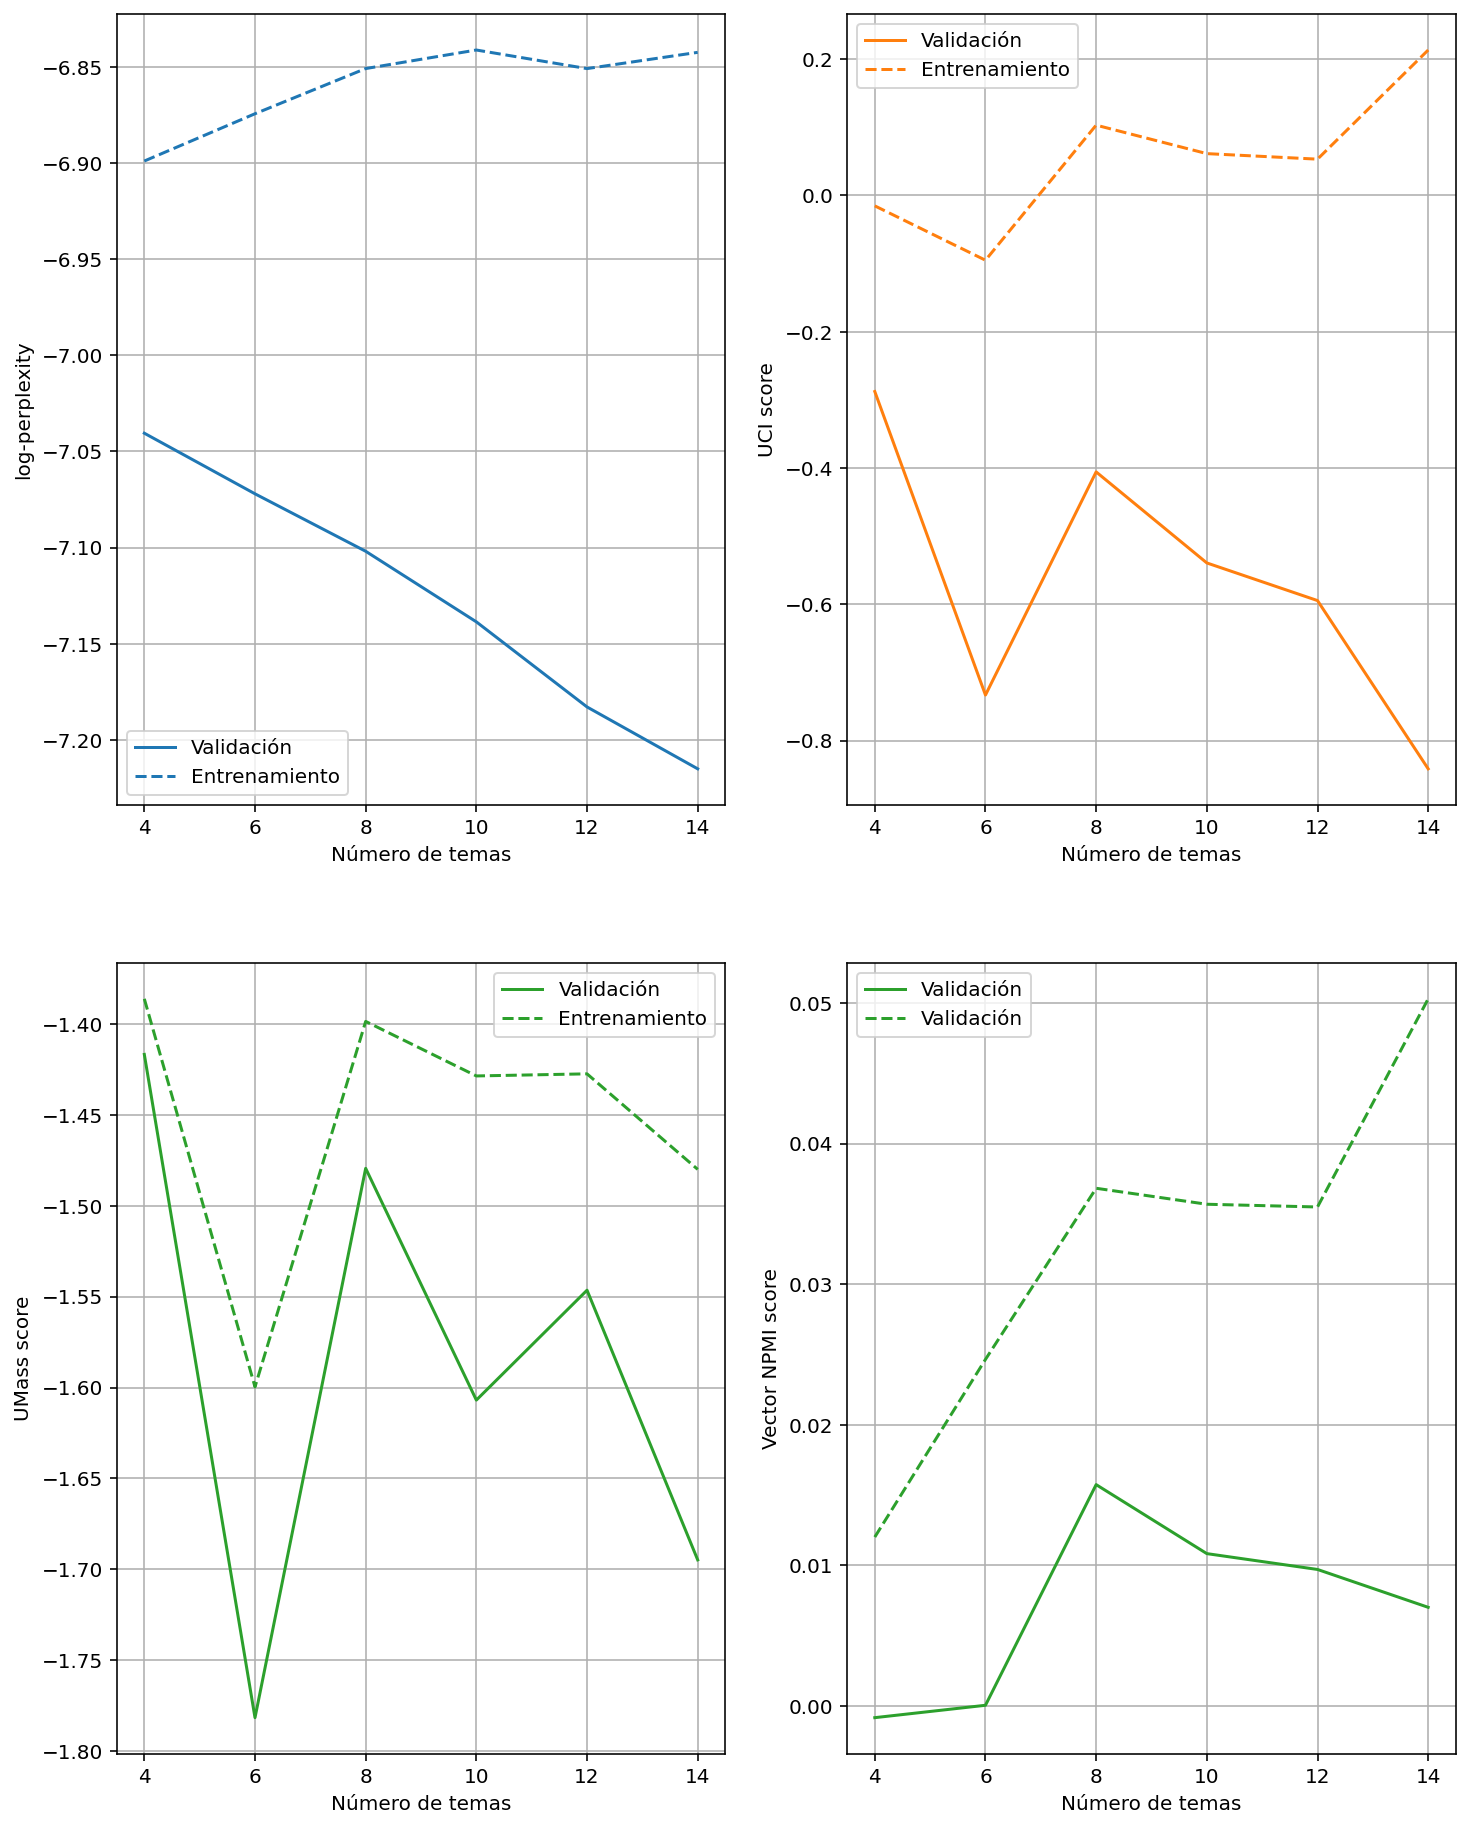

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,16))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

axes[0,0].plot(range(4,K_max,2),L_perp,color=cols[0],label='Validación')
axes[0,0].plot(range(4,K_max,2),L_perp_train,'--',color=cols[0],label='Entrenamiento')
axes[0,0].set_ylabel('log-perplexity')
axes[0,0].set_xlabel('Número de temas')
axes[0,0].legend()
axes[0,0].grid()

axes[0,1].plot(range(4,K_max,2),L_UCI,color=cols[1],label='Validación')
axes[0,1].plot(range(4,K_max,2),L_UCI_train,'--',color=cols[1],label='Entrenamiento')
axes[0,1].set_ylabel('UCI score')
axes[0,1].set_xlabel('Número de temas')
axes[0,1].legend()
axes[0,1].grid()

axes[1,0].plot(range(4,K_max,2),L_mass,color=cols[2],label='Validación')
axes[1,0].plot(range(4,K_max,2),L_mass_train,'--',color=cols[2],label='Entrenamiento')
axes[1,0].set_ylabel('UMass score')
axes[1,0].set_xlabel('Número de temas')
axes[1,0].legend()
axes[1,0].grid()

axes[1,1].plot(range(4,K_max,2),L_NPMI,color=cols[2],label='Validación')
axes[1,1].plot(range(4,K_max,2),L_NPMI_train,'--',color=cols[2],label='Validación')
axes[1,1].set_ylabel('Vector NPMI score')
axes[1,1].set_xlabel('Número de temas')
axes[1,1].legend()
axes[1,1].grid()


Entre realizaciones, los resultados pueden cambiar al tratarse de un dataset de tamaño reducido. A la vista de los resultados, tomemos $K=8$ e imprimamos los temas correspondientes ...

IndexError: list index out of range

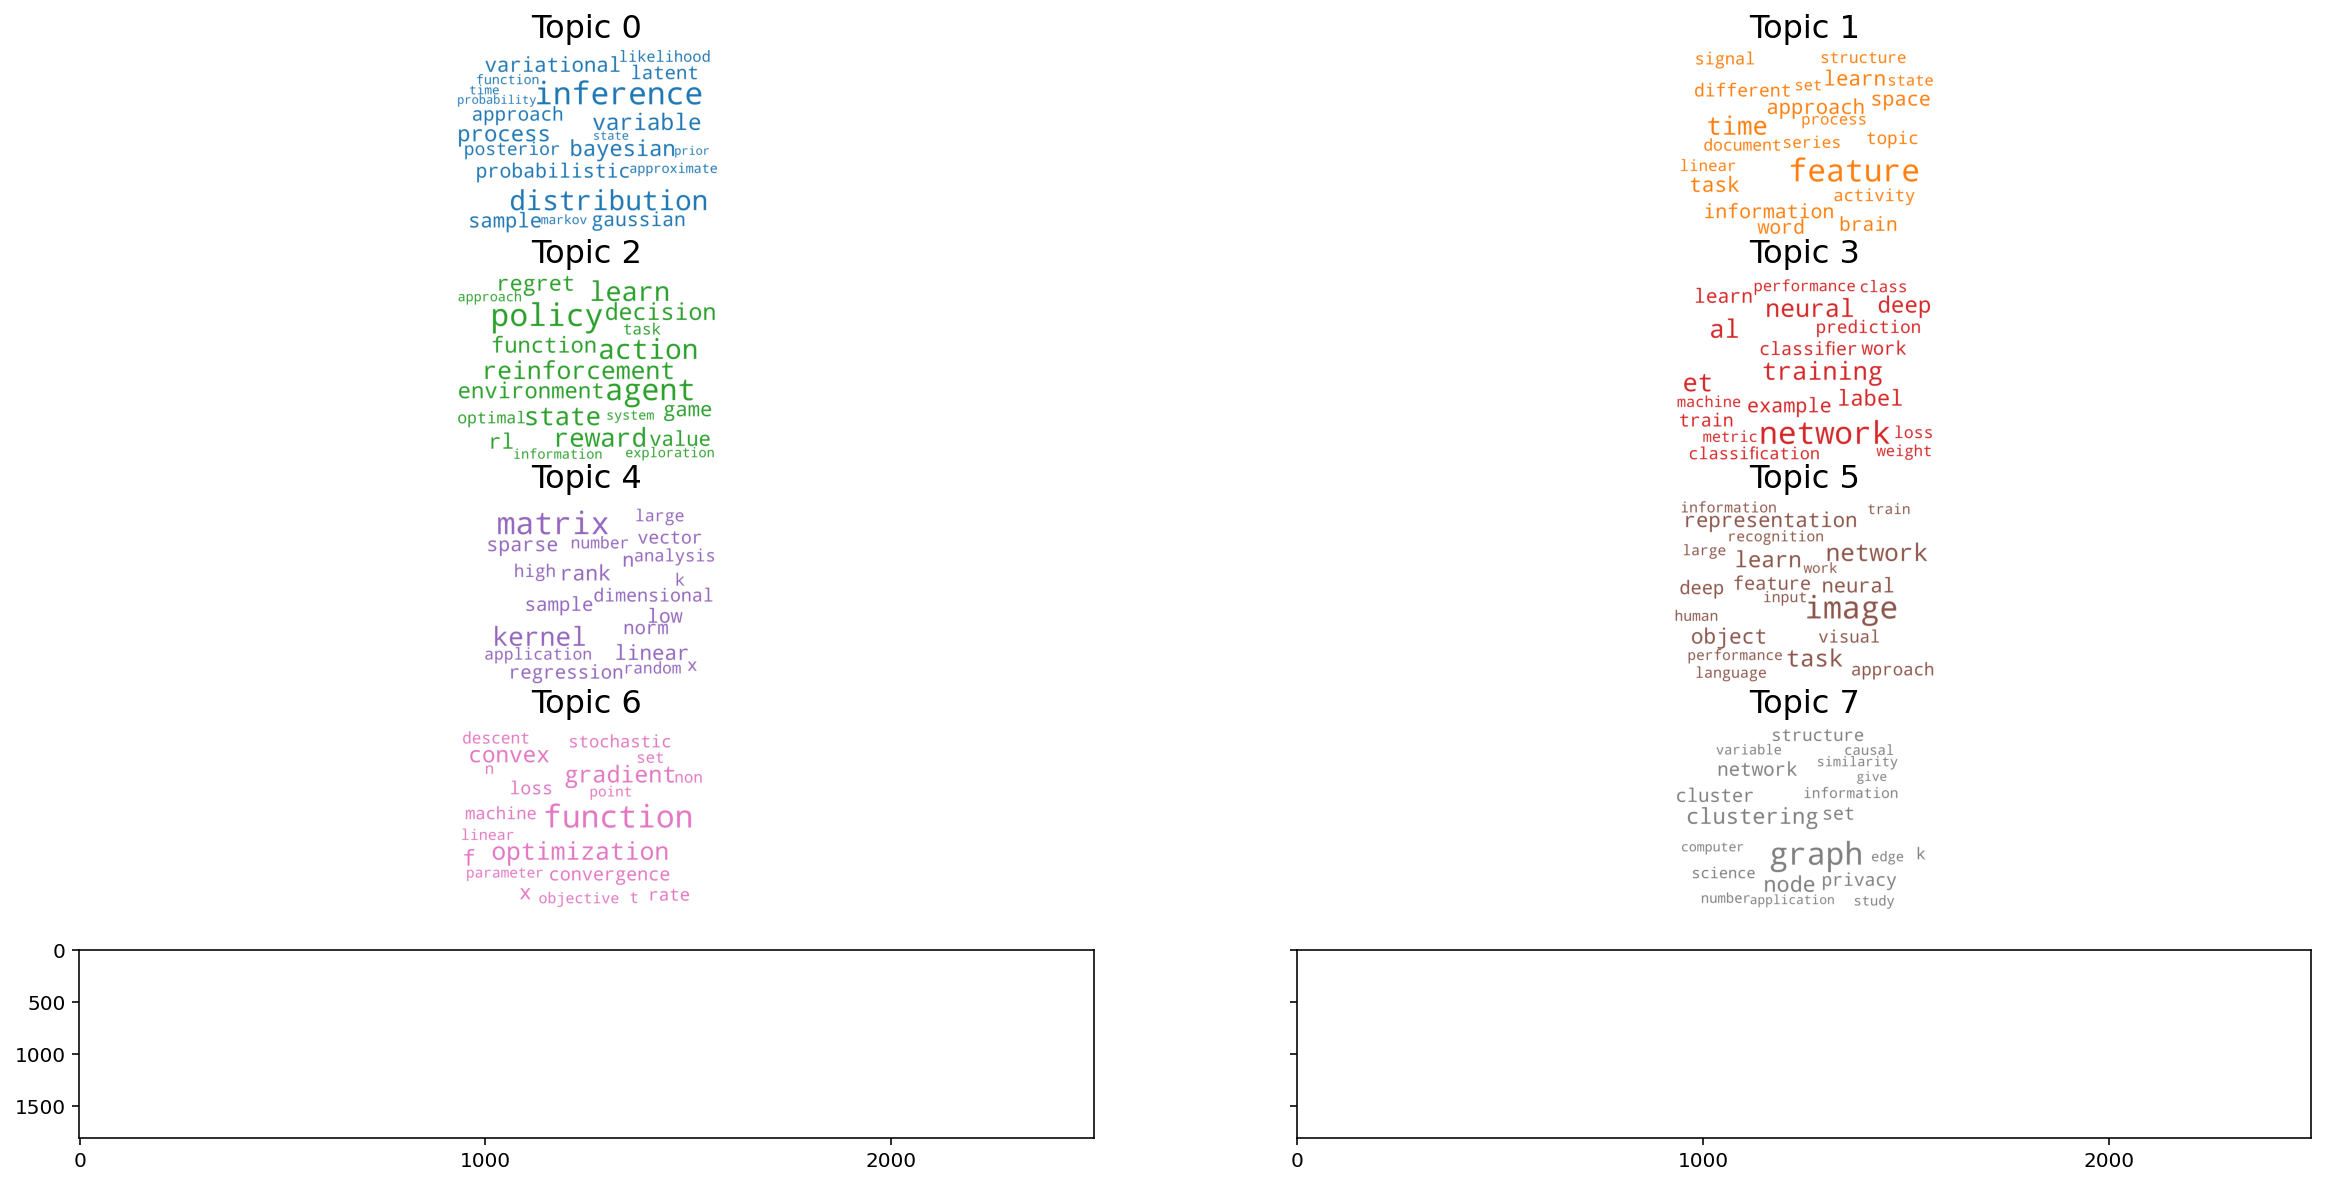

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = topic_models[8].show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(5, 2, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## 5. Visualización con pyLDAvis

[pyLDAvis](https://github.com/bmabey/pyLDAvis) es una librería para visualización de modelos de temas que resume parte del análisis visto anteriormente y permite obtener información adicional. Una explicación detallada de todas la información disponible está en [este artículo](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LDAvis.png' width=800 />

Integrar pyLDAvis dentro de un Jupyter notebook puede dar conflictos en algunas librerías. La forma más sencilla y estable para ejecutar la librería es **guardar la visualización en un html que abrimos externamente**.

In [ ]:
#!pip install pyldavis

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [ ]:
topic_models[10]

In [ ]:
data = pyLDAvis.gensim.prepare(topic_models[10], bow_val, D)
pyLDAvis.save_html(data, "LDAvis10.html")

La visualización de pyLDAvis nos ofrece la siguiente información:

* **Intertopic distance map (panel de la izquierda)** visualización 2D de los temas. El área por tema es proporcional al **número de palabras que pertenecen a cada tema** en nuestro corpus. Recordad que en el modelo generativo cada palabra se muestrea de un tema en particular, durante la inferencia LDA obtenemos el tema asociado a cada palabra.  Además, los circulos se dibujan en un espacio 2D usando el algoritmo [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling), que proyecta la distribución de cada tema $\beta_k$, $k=1,\ldots,K$ en 2D **manteniendo aproximadamente las distancias entre puntos**.

* **Palabras más importantes del corpus**, definidas como aquellas que maximizan el siguiente *saliency score*:

$$s(w) = p(w) * \sum_{k=0}^{K} p(k|w) \log(\frac{ p(k|w)}{p(k)})$$

obsérvese que cada uno de los términos del sumatorio representan la divergencia KL entre la distribución a posteriori de los temas dada la palabra $w$ ($p(k|w)$) y la probabilidad a priori de los mismos ($p(k)$). 

* **Palabras más relevantes por tema**. Si $\beta_{k,w}=p(w|k)$ es la probabilidad de la palabra $w$ en el tema $k$, se calcula su relevancia como 

$$r(w,k|\lambda) = \lambda *\log(\beta_{k,w}) + (1-\lambda) \log(\frac{\beta_{k,w}}{p(w)})$$

donde $p(w)$ es la probabilidad de palabra en el corpus. Para $\lambda=1$ ordenamos las palabras según su probabilidad en el tema, para $\lambda=0$, penalizamos aquellas palabras más probables en el corpus. Esto puede ayudar a interpretar mejor cada tema al filtrar palabras que aparecen en varios temas.




## 6. Dynamic topic models

En el modelo generativo LDA visto en la sección 3, la generación de cada documento es indpendente. Por tanto, una de las suposiciones fundamentales de LDA es el hecho de que el orden de los documentos no importa. Esto puede ser problemático y poco realista cuando se analizan coleciones de documentos escritos durante un largo período do tiempo.  Una aproximación para atajar este problema es utilizar un [modelo de temas dinámico](https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf).

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/DLDA.png' width=800 />

[Fuente](https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf).


Tal y como podemos ver en la figura, tenemos tres colecciones $A$ de documentos indexadas en instantes de tiempo $t,t+1,t+2,\ldots$. La distribución de probabilidad de las palabras por tema en cada insta te de tiempo están correladas con el pasado mediante una cadena de Markov de orden uno. Del mismo modo ocurre con la proporción media de temas por documento.

El objetivo de la inferencia es obtener los temas a lo largo del tiempo ($\beta_t$) así como la proporción de temas en cada documento. La siguiente figura muestra el resultado de aplicar DLDA a la revista *Science* de 1880 a 2002 [[Fuente]](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf). En la figura se muestran las palabras más relevantes de uno de los temas a lo largo del tiempo.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/DLDA2.png' width=800 />


Gensim permite entrenar el modelo LDA dinámico anterior a través de la clase [LdaSeqModel](https://radimrehurek.com/gensim/models/ldaseqmodel.html). La sintáxis es muy parecida a la de LDA, así como las funciones asociadas.

A la hora de instanciar la clase `LdaSeqModel`, ordenaremos los grupos de documentos cronológicamente  e indicaremos cuántos documentos hay en cada grupo. Para ilustrar el modelo, hemos reconfigurado la base de datos de artículos de investigación del siguiente modo:

* 5000 artículos desde 1987 hasta 2015
* Preprocesada filtrando el diccionario para usar 2000 tokens


In [ ]:
papers =  pd.read_csv("papers.csv")

papers.dropna(subset=['title', 'full_text'],inplace=True)

# Nos quedamos con 5000 documentos aleatorios

papers_seqLDA = papers.loc[papers['year']<=2015].sample(n=5000, random_state=1)



<AxesSubplot:>

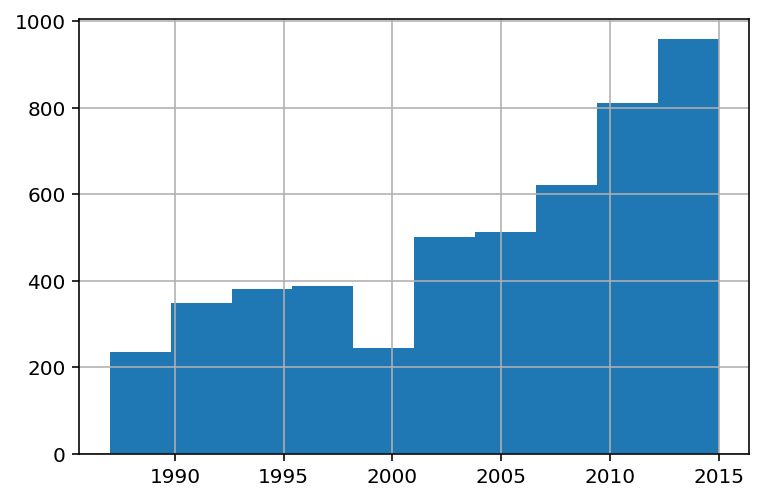

In [ ]:
papers_seqLDA['year'].hist()

In [ ]:
limit = 3000

papers_proc = [nlp(c[:limit]) if len(c)>limit else nlp(c) for c in papers_red['full_text']]

def normalize(doc):
    
    return [w for w in doc if not w.is_stop and not w.is_punct and w.is_alpha] # Solo tokens alfabéticos

# eliminamos stopping words, puntuaciones y tokens sin word embedding
papers_norm = [normalize(c) for c in papers_proc]

# Pasamos a modo texto
papers_text = [[w.lemma_.lower() for w in c] for c in papers_norm]

D = gensim.corpora.Dictionary(papers_text)

no_below = 10 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(keep_n=2000)

corpus_bow = [D.doc2bow(doc) for doc in papers_text]

A continuación, agrupamos los artículos en 5 grupos:

* Artículos publicados antes de 1995
* Artículos publicados entre 1995 y 2000
* Artículos publicados entre 2000 y 2005
* Artículos publicados entre 2005 y 2010
* Artículos publicados entre 2010 y 2015

In [ ]:
years = papers_red['year'].values

In [ ]:
lim1 = 1995

lim2 = 2000

lim3 = 2005

lim4 = 2010

idx_I = np.where(years<=lim1)[0]

idx_II = np.where((years<=lim2) & (years>lim1))[0]

idx_III = np.where((years<=lim3) & (years>lim2))[0]

idx_IV = np.where((years<=lim4) & (years>lim3))[0]

idx_V = np.where(years>lim4)[0]

Ordenamos los artículos de acuerdo a sus grupos ...

In [ ]:
corpus_ordered = [corpus_bow[c] for c in idx_I]+[corpus_bow[c] for c in idx_II]+[corpus_bow[c] for c in idx_III]+[corpus_bow[c] for c in idx_IV]+[corpus_bow[c] for c in idx_V]

Para entrenar el modelo LDA dinámico, procederíamos del siguiente modo

```python

# Entrenamiento LDASeq
K = 5

ldaseq = LdaSeqModel(corpus=corpus_ordered, time_slice=[len(idx_I), len(idx_II), len(idx_III)], num_topics=K,id2word=D,passes=4)

# Guardamos el modelo salvado
ldaseq = LdaSeqModel.save('ldaseq_saved_model_1987_5_topics')
```

---

Como el entrenamiento es bastante pesado, se proporciona el modelo `ldaseq_saved_model_1987_5_topics` ya entrenado

In [ ]:
from gensim.models import LdaSeqModel

ldaseq = LdaSeqModel.load('ldaseq_saved_model_1987_5_topics')

Utilizando la función `ldaseq.print_topics()` podemos acceder a los tópicos del modelo **sin tener en cuenta la estructura temporal** (es decir, un LDA normal):

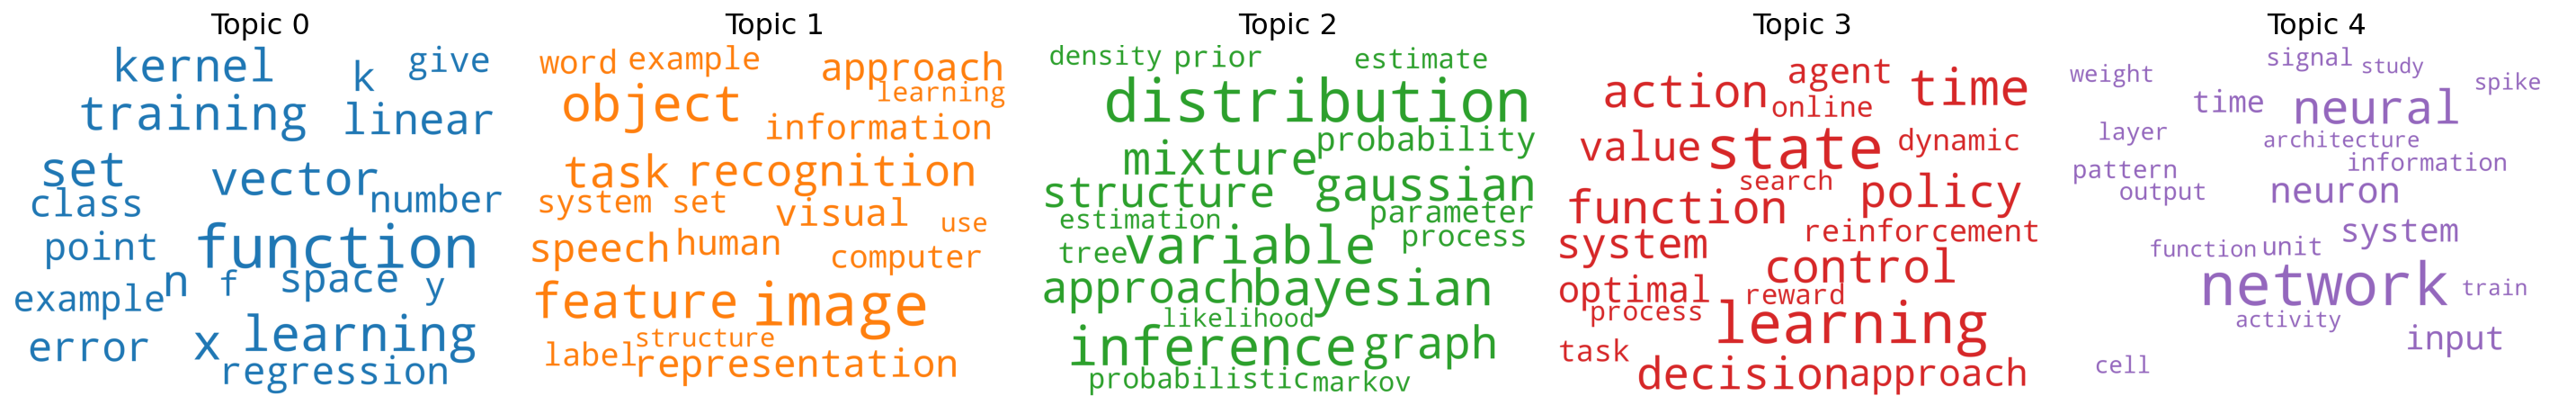

In [ ]:
topics = ldaseq.print_topics()

fig, axes = plt.subplots(1, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

A continuación, podemos estudiar cómo ha evolucionado cada único de los tópicos a lo largo del tiempo, para ello utilizaremos la función `ldaseq.print_topic_times()`:

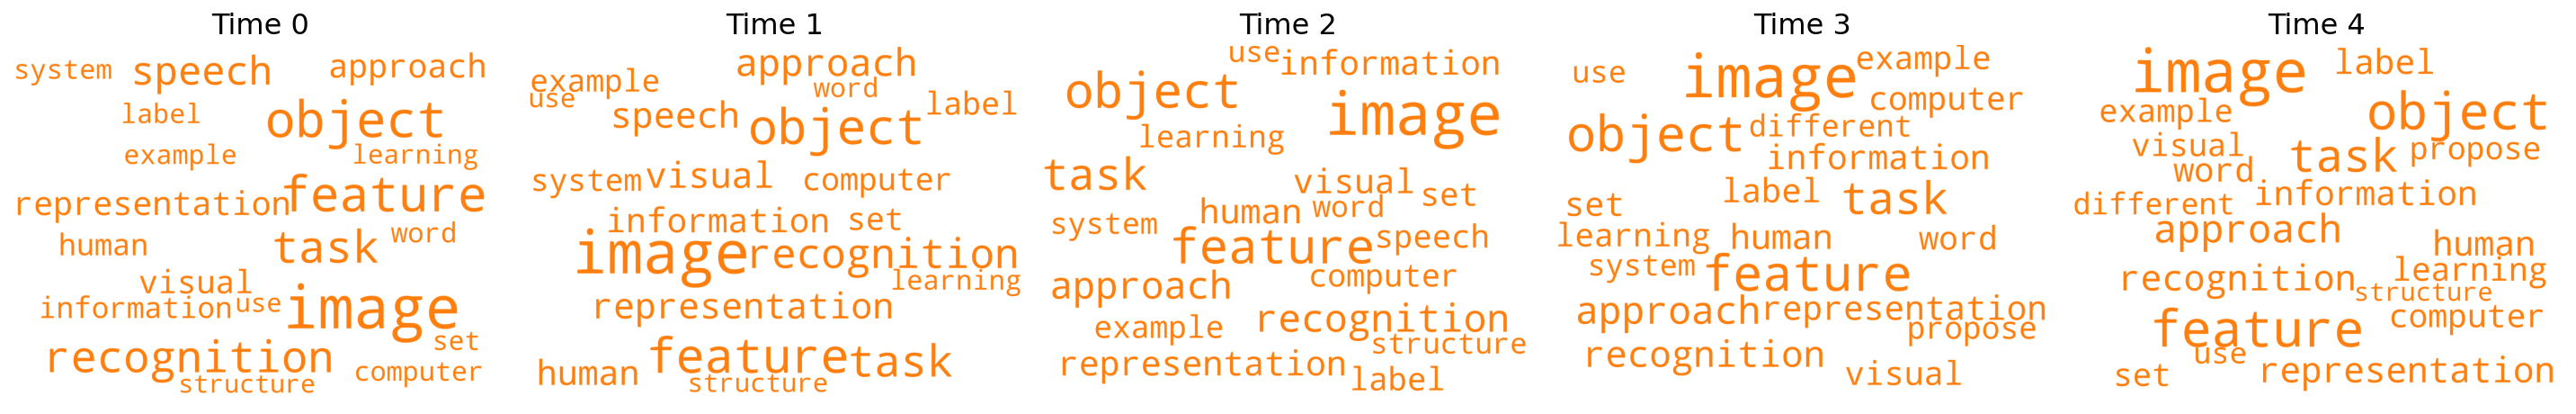

In [ ]:
topic_show = 1

topics = ldaseq.print_topic_times(topic=topic_show)

cloud2 = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[c],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 5, figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    c = topic_show
    fig.add_subplot(ax)
    topic_words = dict(topics[i])
    cloud2.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud2)
    plt.gca().set_title('Time ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Es interesante también representar explictametne el peso de las palabras más probables ...

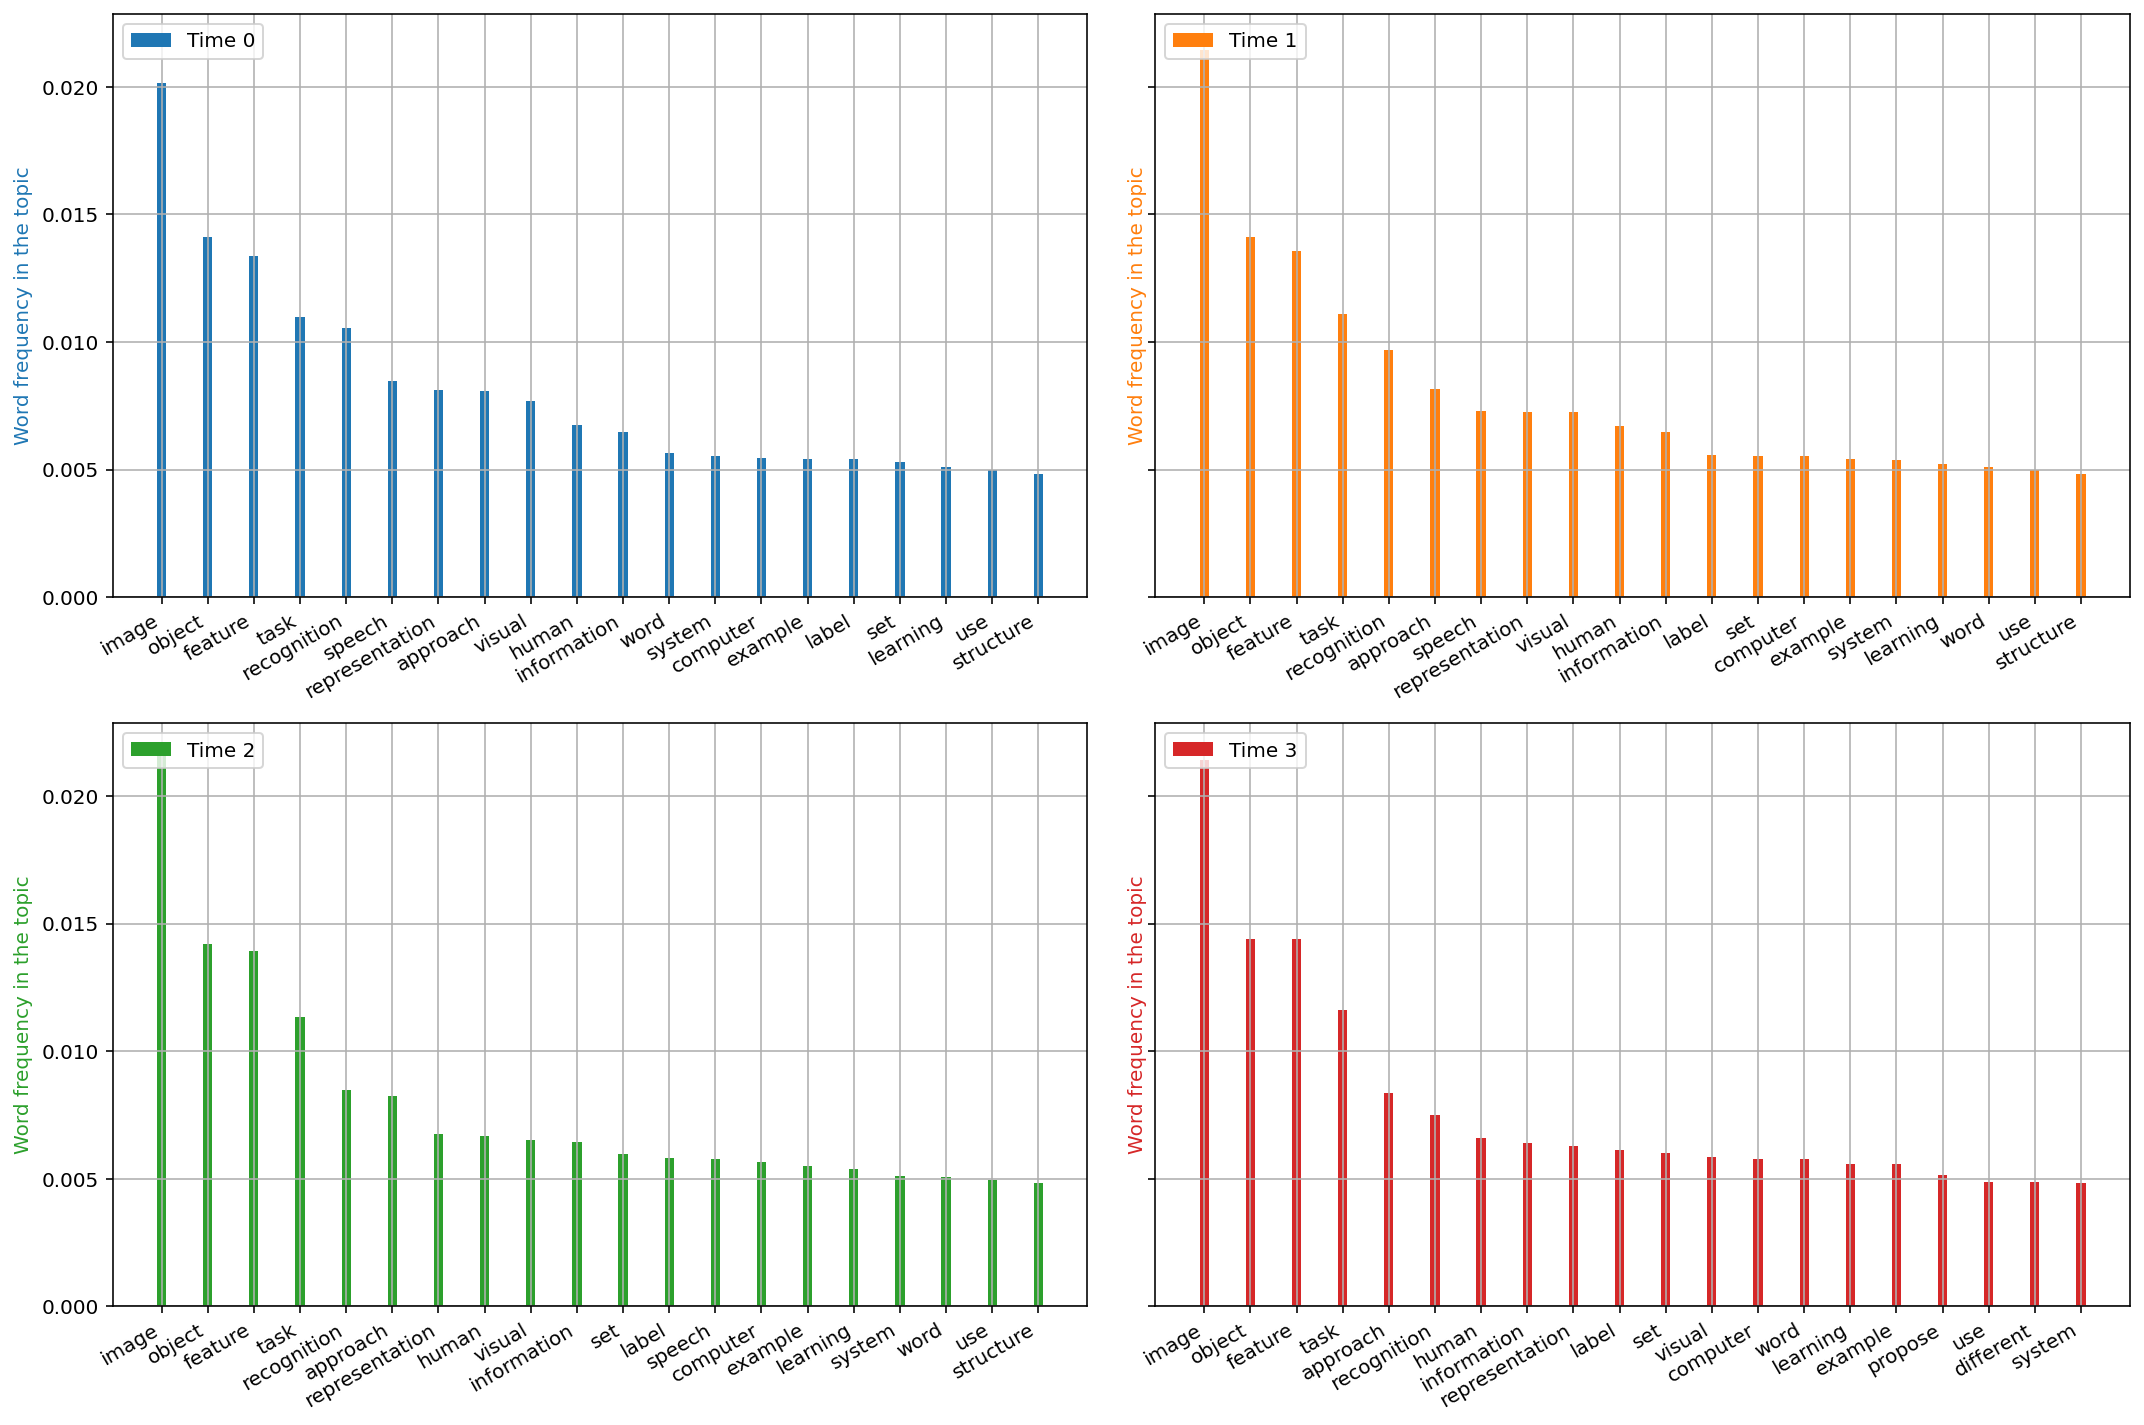

In [ ]:
topics = ldaseq.print_topic_times(topic_show)
#data_flat = [w for w_list in corpus_bow for w in w_list]
#counter = Counter(data_flat)
        
out = []
for t in range(5):
    for word, weight in topics[t]:
        out.append([word, t , weight, counter[word]])
    
df = pd.DataFrame(out, columns=['word', 'Time', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    
    ax.bar(x='word', height="importance", data=df.loc[df.Time==i, :], color=cols[i], width=0.2, label='Time '+str(i))
    ax.set_ylabel('Word frequency in the topic', color=cols[i])
    ax.set_xticklabels(df.loc[df.Time==i, 'word'], rotation=30, horizontalalignment= 'right',)
    ax.legend(loc='upper left'); 
    ax.grid()
    
fig.tight_layout(w_pad=2)    
plt.show()